# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'LSTM'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'LSTM_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'LSTM_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time     OD_1-1      OD_1-2       OD_1-3      OD_1-4  \
0  2004-03-01-00-00  26.666667  522.208000  1641.338667  335.728000   
1  2004-03-01-00-05  26.666667  465.701333   868.098667  148.346667   
2  2004-03-01-00-10  53.333333  375.261333  1082.378667  276.136000   
3  2004-03-01-00-15  67.274667  498.360000  1332.205333  121.269333   
4  2004-03-01-00-20  26.666667  723.962667  1428.480000  165.938667   

       OD_1-5       OD_1-6      OD_1-7       OD_1-8      OD_1-9  ...  \
0  413.032000   489.874667  365.077333   817.869333  452.061333  ...   
1  398.701333  1821.269333  402.144000  1090.848000  585.202667  ...   
2  453.426667  1703.384000  407.152000   403.664000  853.005333  ...   
3  425.168000   794.472000  506.746667   142.328000  818.728000  ...   
4  459.965333   403.757333  303.256000   257.877333  848.208000  ...   

        OD_12-3       OD_12-4       OD_12-5       OD_12-6       OD_12-7  \
0  66541.197333  36063.421333  15439.312000  62781.813333  32642.733333   
1  62246.088000  34109.810667  15664.965333  56823.610667  24912.210667   
2  70181.930667  29905.896000  19918.581333  58658.568000  19036.714667   
3  74490.416000  44822.789333  16250.042667  50589.922667  18758.725333   
4  69881.266667  44536.856000  18448.840000  51095.165333  18614.133333   

         OD_12-8        OD_12-9     OD_12-10      OD_12-11       OD_12-12  
0   91675.626667  133661.405333  1980.576000  29760.202667  187653.482667  
1  100567.461333  137277.728000  4411.589333  30667.266667  190925.981333  
2   92415.480000  153845.554667  5300.653333  39990.880000  218742.773333  
3   97793.093333  159339.533333  4490.272000  38331.688000  265665.077333  
4   93446.560000  151623.424000  3487.808000  43462.373333  210540.786667  

[5 rows x 145 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

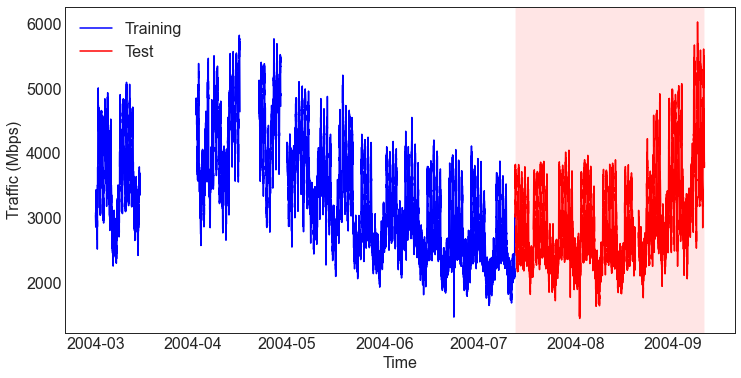

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

5.940447088662937


In [26]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

48096


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(48086, 10, 144)

In [32]:
y_data.shape

(48086, 1, 144)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

**This format is required by tsai: [data size, input channels, input historical steps].**

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(48086, 144)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

30773

In [40]:
valid_length

7694

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(30773, 144, 10)

In [43]:
y_train.shape

(30773, 144)

In [44]:
X_valid.shape

(7694, 144, 10)

In [45]:
y_valid.shape

(7694, 144)

In [46]:
X_test.shape

(9619, 144, 10)

In [47]:
y_test.shape

(9619, 144)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(38467, 144, 10)

In [50]:
y.shape

(38467, 144)

In [51]:
splits

((#30773) [0,1,2,3,4,5,6,7,8,9...],
 (#7694) [30773,30774,30775,30776,30777,30778,30779,30780,30781,30782...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#38467) [(TSTensor(vars:144, len:10), tensor([2.0469e-03, 5.1440e-02, 1.4299e-01, 1.5172e-02, 3.1831e-02, 2.1060e-02,
        5.6545e-02, 2.7428e-02, 2.8036e-01, 0.0000e+00, 4.0722e-02, 8.6615e-02,
        5.2351e-02, 2.0172e-01, 2.2308e-01, 5.7753e-02, 2.0265e-02, 1.5293e-01,
        9.8783e-02, 1.2363e-01, 1.7657e-01, 3.3181e-02, 2.1478e-01, 3.0738e-01,
        9.3064e-02, 9.6376e-02, 1.5660e-01, 3.1830e-02, 4.6944e-02, 1.3623e-01,
        4.7996e-02, 9.0038e-02, 3.8663e-02, 3.1614e-02, 1.1989e-01, 4.8892e-02,
        7.9847e-03, 2.8893e-02, 1.8501e-01, 3.5594e-02, 1.7775e-02, 6.8981e-02,
        8.2558e-02, 8.7485e-02, 1.3270e-01, 7.0169e-02, 1.0452e-01, 2.8641e-02,
        2.3876e-01, 3.3501e-02, 1.7263e-01, 9.0359e-02, 4.2771e-02, 4.5059e-01,
        2.0892e-01, 1.9877e-02, 5.5563e-02, 1.0113e-01, 1.0701e-01, 3.5482e-02,
        1.2049e-01, 1.0425e-01, 4.3749e-01, 9.8969e-02, 7.4077e-02, 9.2987e-02,
        1.2642e-01, 1.1211e-01, 1.5237e-01, 7.5094e-02, 2.2026e-01, 1.6917e-01,
 

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1729f694248>,
 'lr': <hyperopt.pyll.base.Apply at 0x1729f694148>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1729f694d08>,
 'patience': <hyperopt.pyll.base.Apply at 0x1729ed51b48>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1729f6ed648>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1729fee7088>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1729f6d9588>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1729f6d1408>}

In [55]:
# clear memory 
gc.collect()

0

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

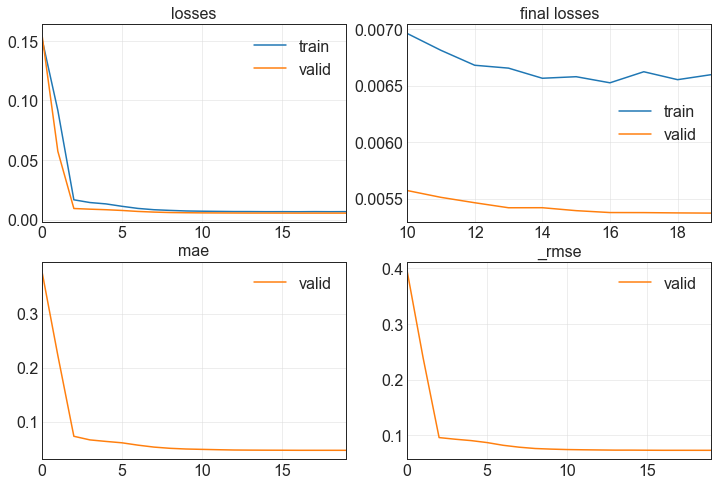

41.48004484176636                                                                                                      
[0.0065977852791547775, 0.005372124724090099, 0.04688753932714462, 0.07329478114843369]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  1%|▍                                           | 1/100 [00:53<1:19:54, 48.43s/trial, best loss: 0.005372124724090099]

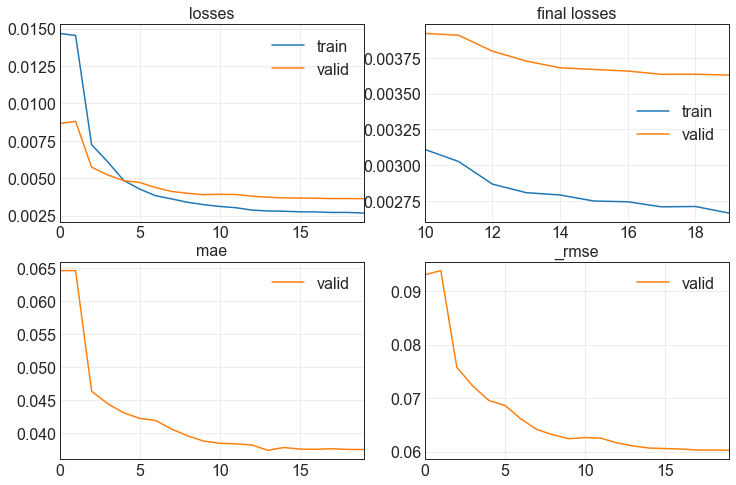

264.21993112564087                                                                                                     
[0.002663613297045231, 0.003629399696364999, 0.03747028112411499, 0.06024450436234474]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  2%|▊                                          | 2/100 [05:22<3:07:06, 114.56s/trial, best loss: 0.003629399696364999]

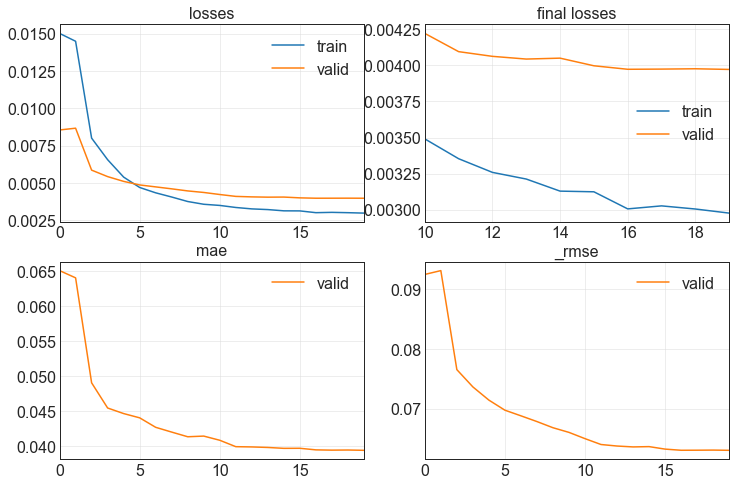

183.45546102523804                                                                                                     
[0.002975806361064315, 0.0039724078960716724, 0.03939250484108925, 0.0630270466208458]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  3%|█▎                                         | 3/100 [08:30<3:40:56, 136.66s/trial, best loss: 0.003629399696364999]

No improvement since epoch 48: early stopping                                                                          
  3%|█▎                                         | 3/100 [11:14<3:40:56, 136.66s/trial, best loss: 0.003629399696364999]

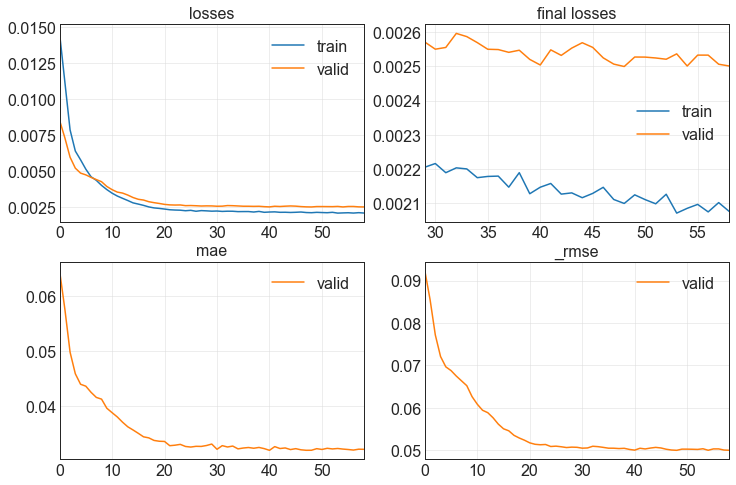

165.08652687072754                                                                                                     
[0.0020763599313795567, 0.0025010942481458187, 0.03216777369379997, 0.05001094192266464]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  4%|█▋                                        | 4/100 [11:20<3:54:34, 146.61s/trial, best loss: 0.0025010942481458187]

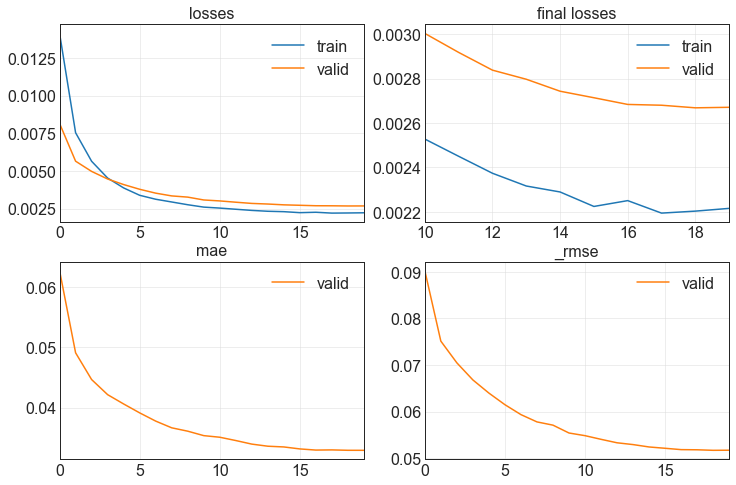

173.20596075057983                                                                                                     
[0.0022151186130940914, 0.0026706873904913664, 0.03290851041674614, 0.051678694784641266]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
  5%|██                                        | 5/100 [14:18<4:06:59, 156.00s/trial, best loss: 0.0025010942481458187]

No improvement since epoch 46: early stopping                                                                          
  5%|██                                        | 5/100 [15:37<4:06:59, 156.00s/trial, best loss: 0.0025010942481458187]

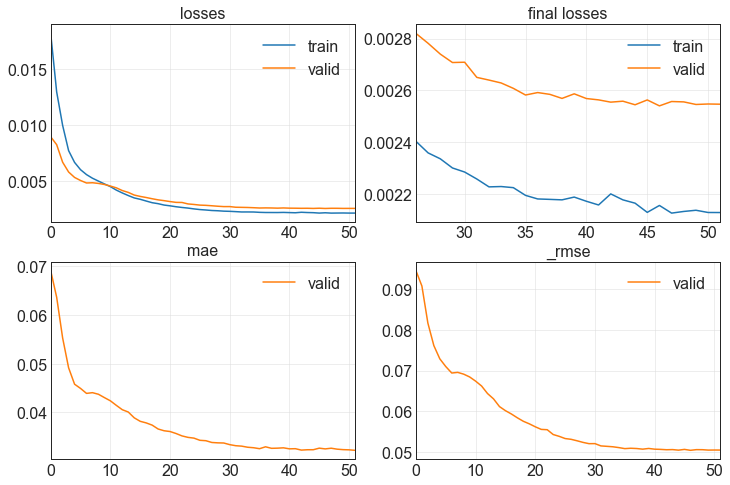

79.64109778404236                                                                                                      
[0.0021283249370753765, 0.0025465628132224083, 0.03222760558128357, 0.0504634790122509]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  6%|██▌                                       | 6/100 [15:42<3:30:46, 134.53s/trial, best loss: 0.0025010942481458187]

No improvement since epoch 26: early stopping                                                                          
  6%|██▌                                       | 6/100 [18:44<3:30:46, 134.53s/trial, best loss: 0.0025010942481458187]

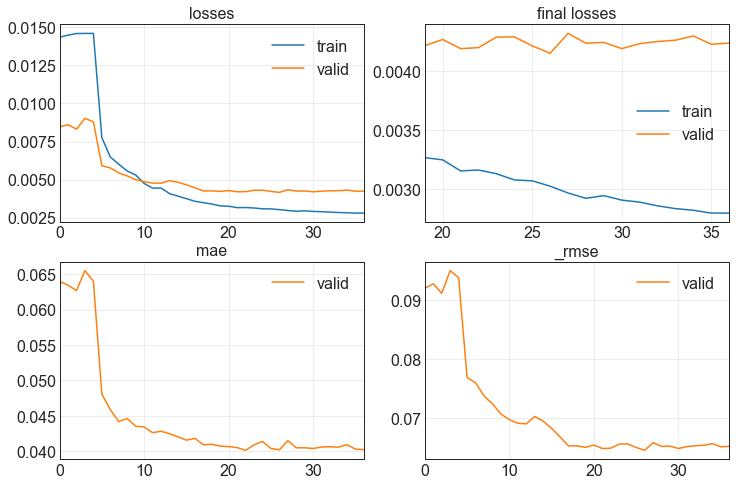

182.12623739242554                                                                                                     
[0.0027922443114221096, 0.004242199007421732, 0.040223393589258194, 0.06513217091560364]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
  7%|██▉                                       | 7/100 [18:49<3:52:52, 150.24s/trial, best loss: 0.0025010942481458187]

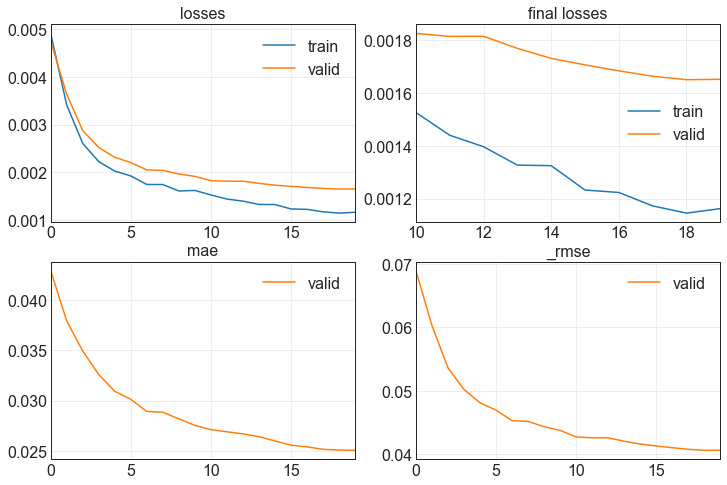

433.9940469264984                                                                                                      
[0.0011618358548730612, 0.001651498954743147, 0.02507926896214485, 0.04063864424824715]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
  8%|███▍                                       | 8/100 [26:08<6:03:05, 236.80s/trial, best loss: 0.001651498954743147]

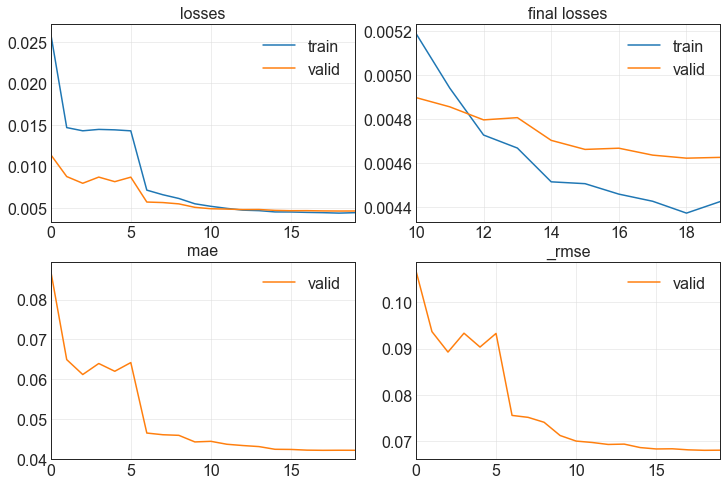

137.46358585357666                                                                                                     
[0.004424489103257656, 0.004625335801392794, 0.04213504120707512, 0.06800981611013412]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
  9%|███▊                                       | 9/100 [28:30<5:16:09, 208.45s/trial, best loss: 0.001651498954743147]

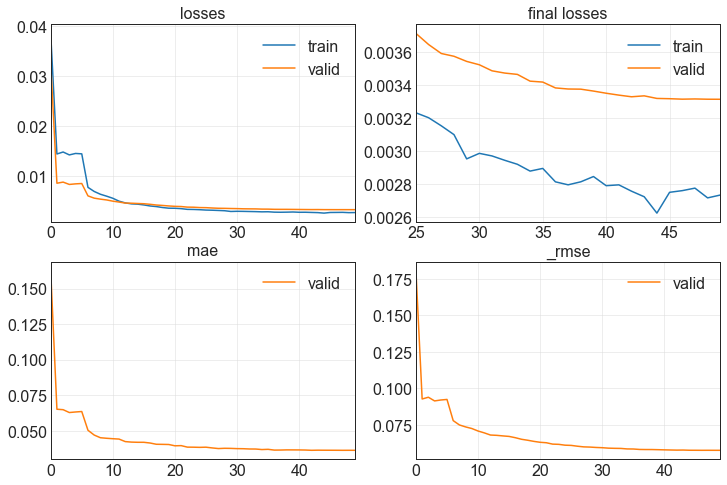

1319.9103815555573                                                                                                     
[0.0027337432838976383, 0.0033132238313555717, 0.03624419495463371, 0.05756059288978577]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 10%|████                                     | 10/100 [50:35<13:34:57, 543.30s/trial, best loss: 0.001651498954743147]

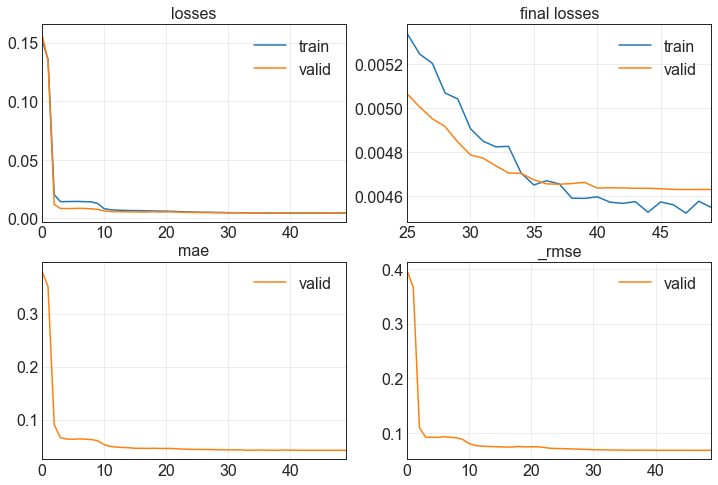

460.00222539901733                                                                                                     
[0.0045468974858522415, 0.004629265516996384, 0.04224172234535217, 0.0680387020111084]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 11%|████▌                                    | 11/100 [58:20<12:51:03, 519.81s/trial, best loss: 0.001651498954743147]

No improvement since epoch 48: early stopping                                                                          
 11%|████▎                                  | 11/100 [1:08:20<12:51:03, 519.81s/trial, best loss: 0.001651498954743147]

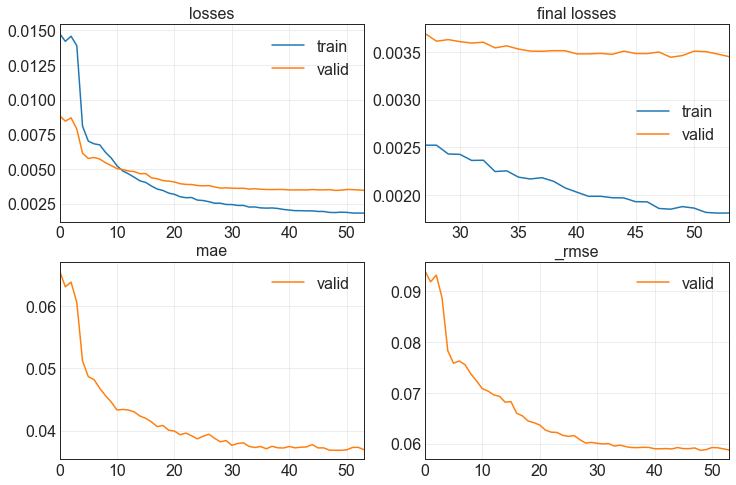

601.1392421722412                                                                                                      
[0.0018093825783580542, 0.003451309632509947, 0.03690704330801964, 0.058747854083776474]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 12%|████▋                                  | 12/100 [1:08:26<13:20:18, 545.67s/trial, best loss: 0.001651498954743147]

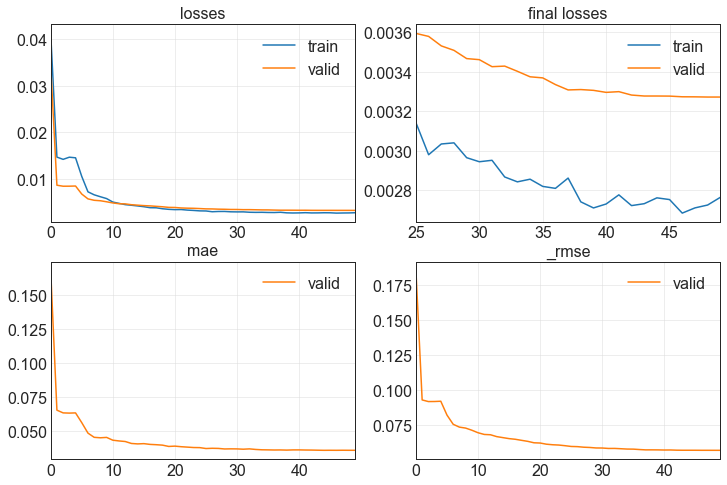

1314.6745779514313                                                                                                     
[0.002765265991911292, 0.003272498492151499, 0.035940613597631454, 0.05720575898885727]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 13%|█████                                  | 13/100 [1:30:25<18:47:54, 777.87s/trial, best loss: 0.001651498954743147]

No improvement since epoch 17: early stopping                                                                          
 13%|█████                                  | 13/100 [1:32:59<18:47:54, 777.87s/trial, best loss: 0.001651498954743147]

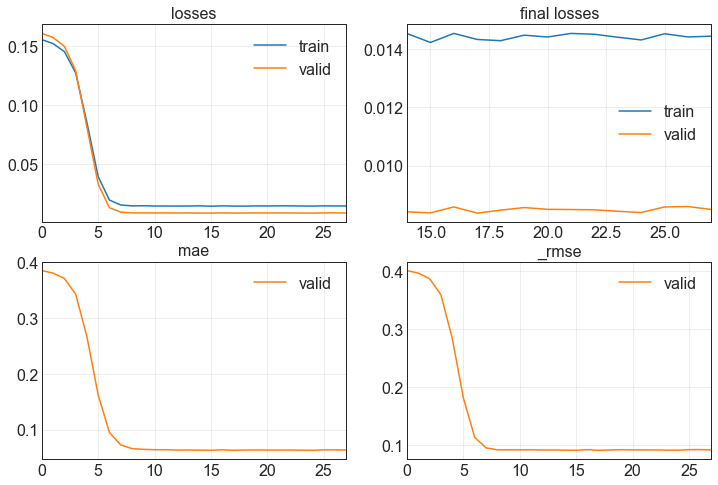

154.2925088405609                                                                                                      
[0.014446415938436985, 0.008487248793244362, 0.06320352852344513, 0.09212626516819]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 14%|█████▍                                 | 14/100 [1:33:04<14:08:54, 592.27s/trial, best loss: 0.001651498954743147]

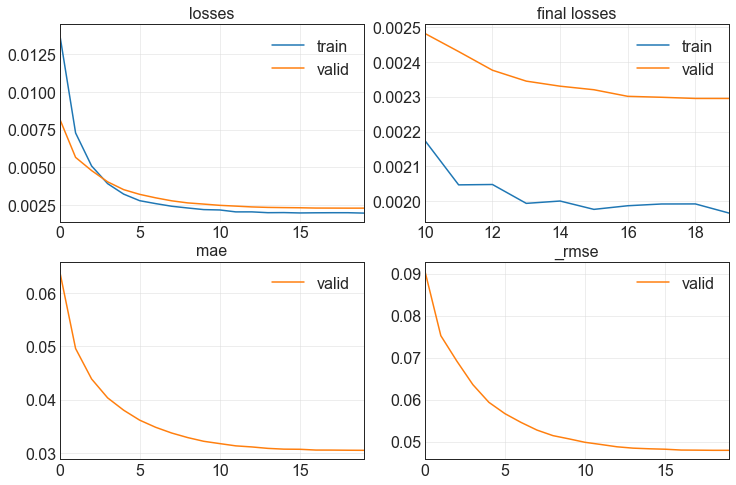

127.59049844741821                                                                                                     
[0.0019663393031805754, 0.0022949883714318275, 0.030478762462735176, 0.04790604114532471]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 15%|█████▊                                 | 15/100 [1:35:17<10:43:33, 454.27s/trial, best loss: 0.001651498954743147]

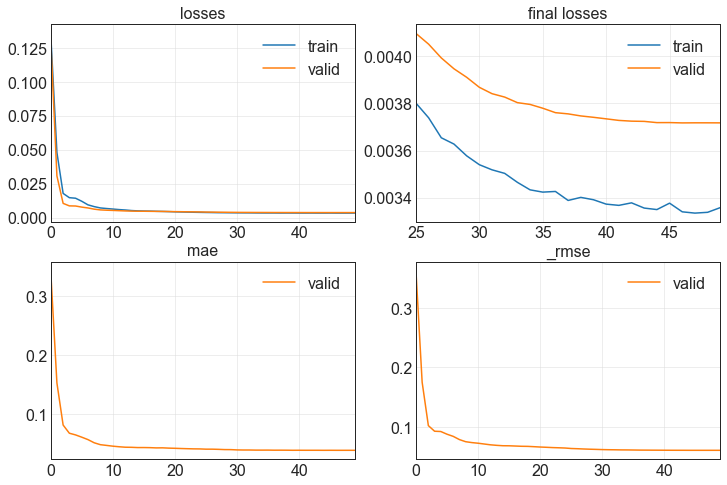

75.13600063323975                                                                                                      
[0.0033577154390513897, 0.0037174043245613575, 0.03846846893429756, 0.06097051501274109]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 16%|██████▍                                 | 16/100 [1:36:37<7:58:42, 341.93s/trial, best loss: 0.001651498954743147]

No improvement since epoch 37: early stopping                                                                          
 16%|██████▍                                 | 16/100 [2:02:36<7:58:42, 341.93s/trial, best loss: 0.001651498954743147]

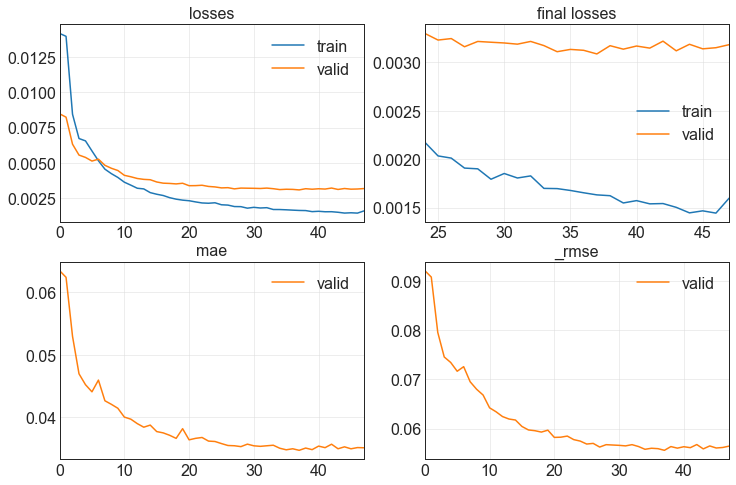

1559.379142522812                                                                                                      
[0.0015973977278918028, 0.003183227963745594, 0.0351274274289608, 0.05642010271549225]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 17%|██████▋                                | 17/100 [2:02:41<16:20:16, 708.63s/trial, best loss: 0.001651498954743147]

No improvement since epoch 9: early stopping                                                                           
 17%|██████▋                                | 17/100 [2:10:27<16:20:16, 708.63s/trial, best loss: 0.001651498954743147]

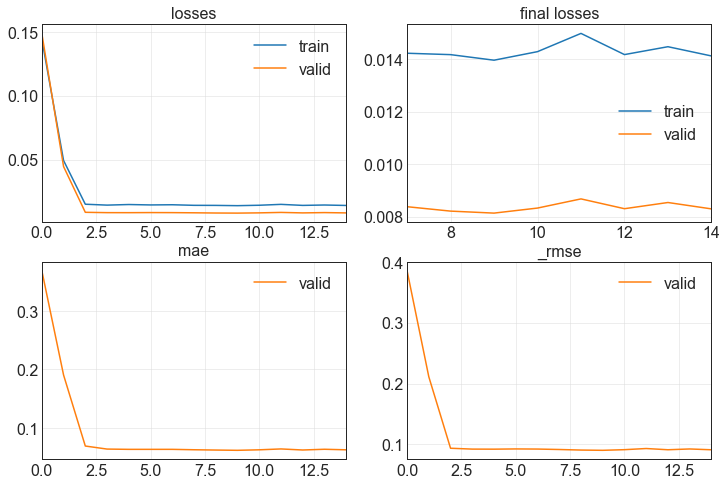

466.74932861328125                                                                                                     
[0.014115960337221622, 0.008294420316815376, 0.06260623782873154, 0.09107369929552078]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 18%|███████                                | 18/100 [2:10:32<14:31:15, 637.51s/trial, best loss: 0.001651498954743147]

No improvement since epoch 20: early stopping                                                                          
 18%|███████                                | 18/100 [2:12:37<14:31:15, 637.51s/trial, best loss: 0.001651498954743147]

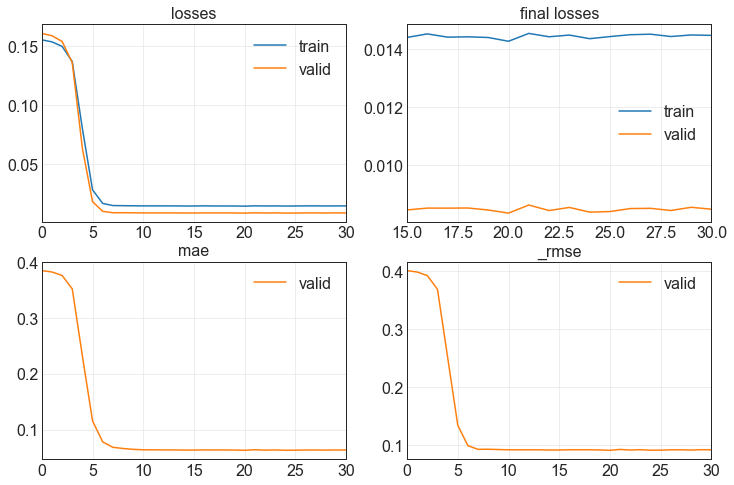

125.19287943840027                                                                                                     
[0.014467551372945309, 0.008487795479595661, 0.06326935440301895, 0.09212923049926758]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 19%|███████▍                               | 19/100 [2:12:42<10:55:03, 485.22s/trial, best loss: 0.001651498954743147]

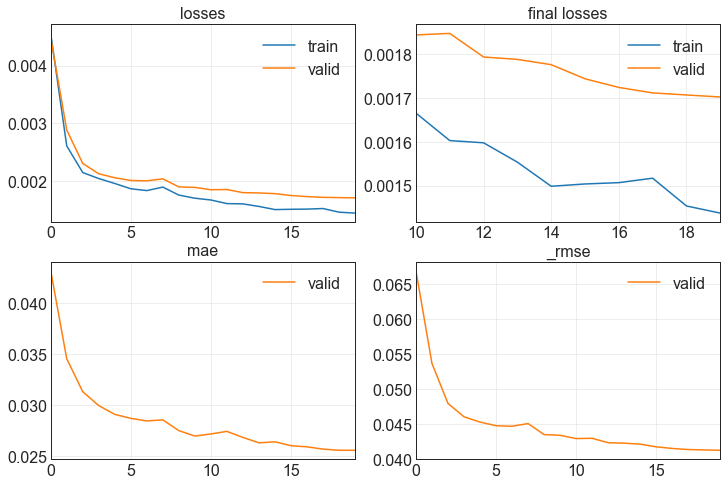

270.82345056533813                                                                                                     
[0.0014374579768627882, 0.0017020564991980791, 0.025601310655474663, 0.04125599563121796]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 20%|████████                                | 20/100 [2:17:18<9:23:04, 422.30s/trial, best loss: 0.001651498954743147]

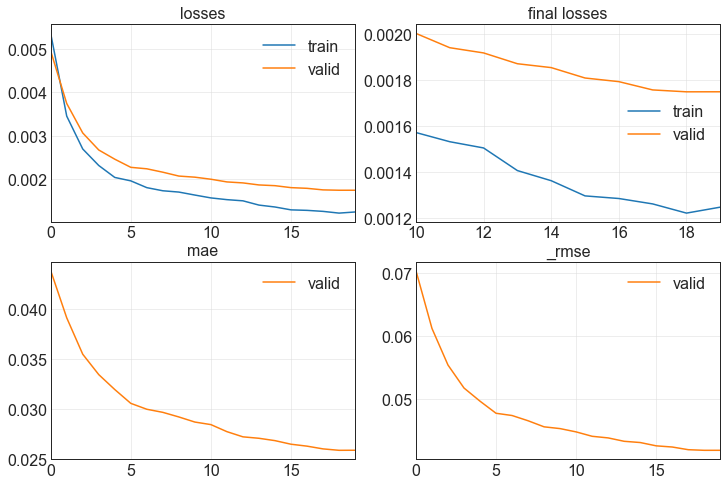

364.3326816558838                                                                                                      
[0.001247950131073594, 0.0017483356641605496, 0.02590012736618519, 0.04181310534477234]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 21%|████████▍                               | 21/100 [2:23:27<8:55:00, 406.33s/trial, best loss: 0.001651498954743147]

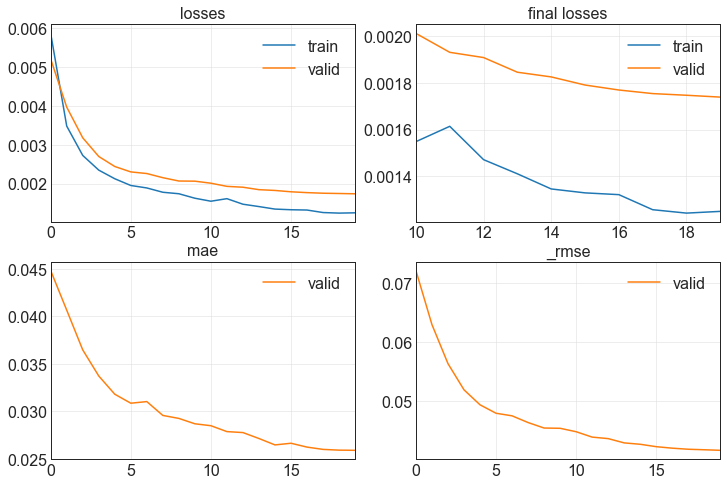

367.84246253967285                                                                                                     
[0.0012501159217208624, 0.0017393538728356361, 0.02589116245508194, 0.04170556366443634]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 22%|████████▊                               | 22/100 [2:29:40<8:35:08, 396.27s/trial, best loss: 0.001651498954743147]

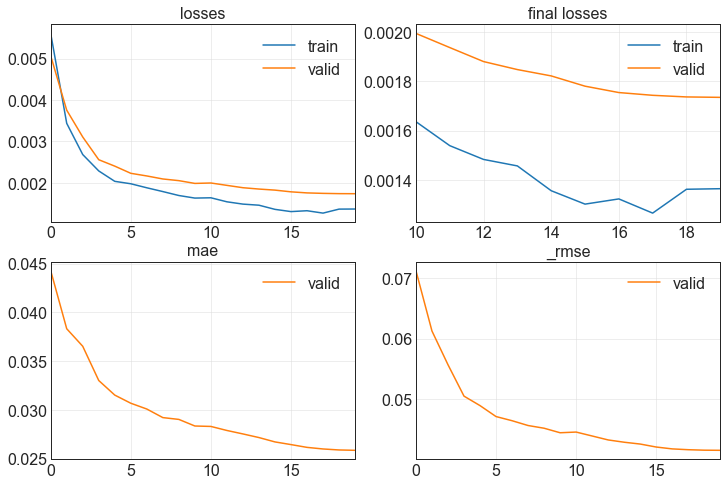

361.03226232528687                                                                                                     
[0.0013651540502905846, 0.0017347820103168488, 0.0258600153028965, 0.041650719940662384]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 23%|█████████▏                              | 23/100 [2:35:45<8:16:49, 387.13s/trial, best loss: 0.001651498954743147]

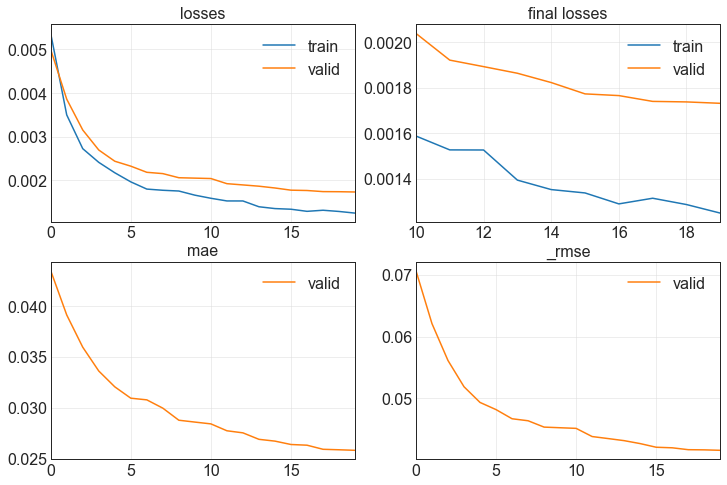

350.18846678733826                                                                                                     
[0.0012476462870836258, 0.0017310383263975382, 0.025808289647102356, 0.04160575196146965]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 24%|█████████▌                              | 24/100 [2:41:40<7:58:07, 377.47s/trial, best loss: 0.001651498954743147]

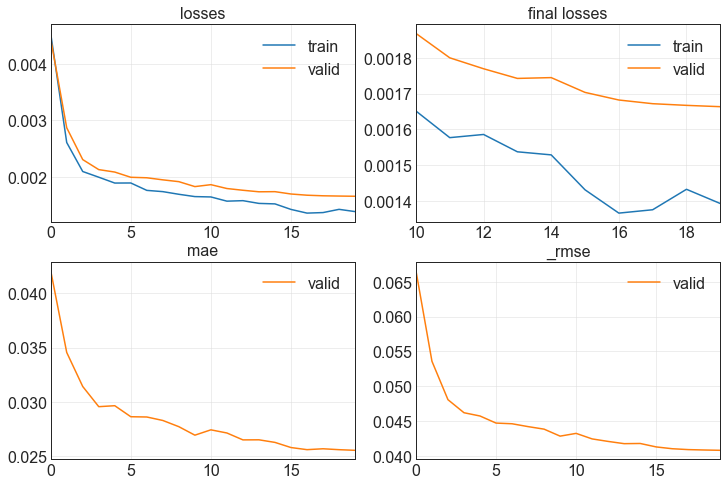

259.7409613132477                                                                                                      
[0.0013934290036559105, 0.0016636524815112352, 0.025515766814351082, 0.04078790172934532]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 25%|██████████                              | 25/100 [2:46:05<7:09:27, 343.57s/trial, best loss: 0.001651498954743147]

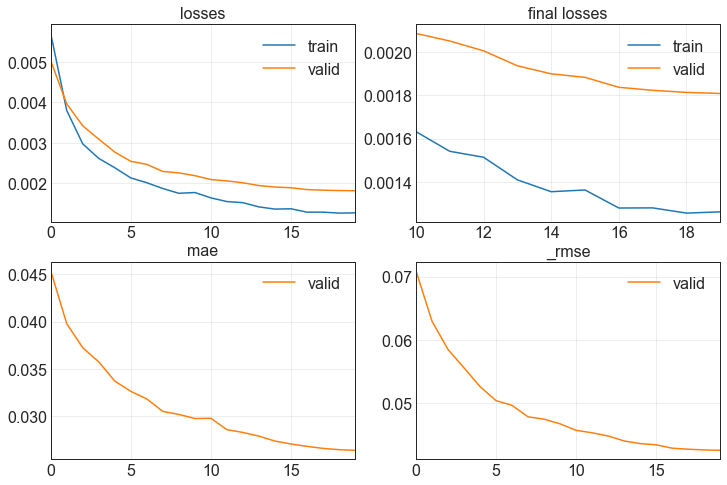

286.13401222229004                                                                                                     
[0.0012606714153662324, 0.0018093364778906107, 0.02642672136425972, 0.04253629595041275]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 26%|██████████▍                             | 26/100 [2:50:56<6:44:14, 327.76s/trial, best loss: 0.001651498954743147]

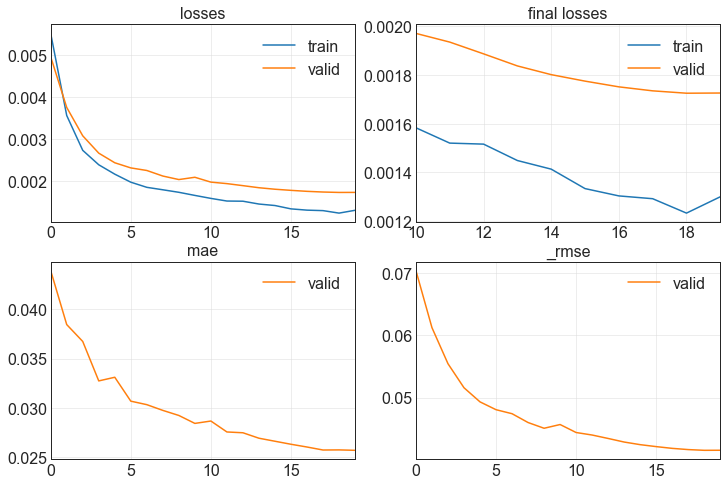

350.4216899871826                                                                                                      
[0.0013000977924093604, 0.0017262982437387109, 0.02567249722778797, 0.041548747569322586]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 27%|██████████▊                             | 27/100 [2:56:51<6:48:45, 335.96s/trial, best loss: 0.001651498954743147]

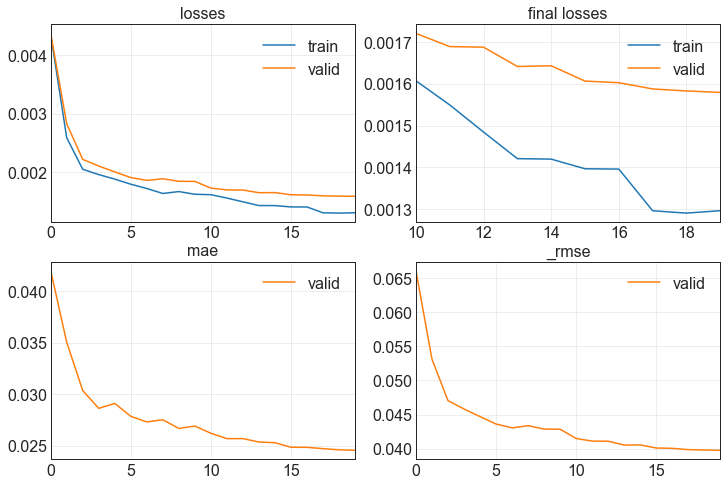

282.60060143470764                                                                                                     
[0.0012969124363735318, 0.0015792188933119178, 0.024549569934606552, 0.03973938524723053]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 28%|██████████▉                            | 28/100 [3:01:38<6:25:39, 321.38s/trial, best loss: 0.0015792188933119178]

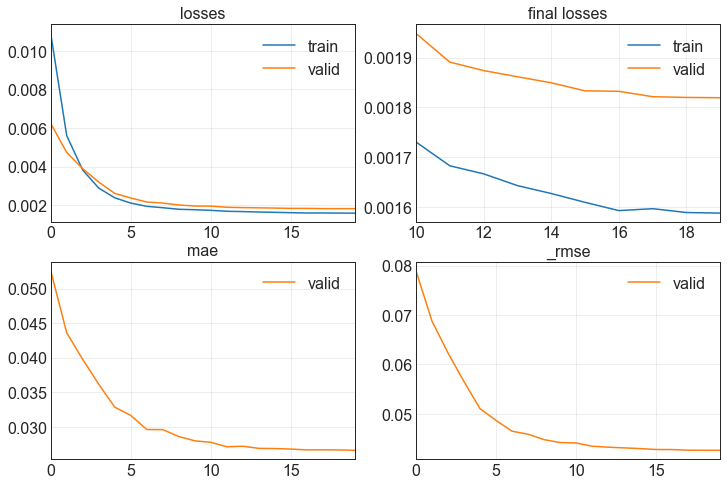

41.6742844581604                                                                                                       
[0.0015882571460679173, 0.0018195620505139232, 0.02658182568848133, 0.04265632480382919]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 29%|███████████▎                           | 29/100 [3:02:24<4:42:40, 238.89s/trial, best loss: 0.0015792188933119178]

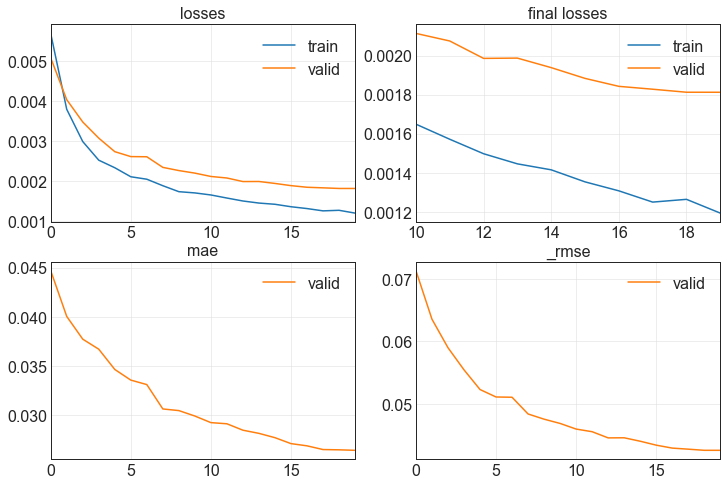

285.7195017337799                                                                                                      
[0.0011934858048334718, 0.0018120422028005123, 0.026439866051077843, 0.042568083852529526]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 30%|███████████▋                           | 30/100 [3:07:15<4:56:43, 254.34s/trial, best loss: 0.0015792188933119178]

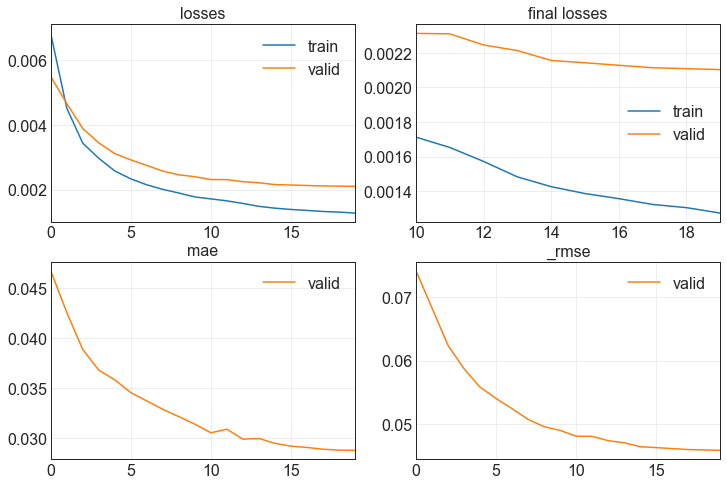

290.61791920661926                                                                                                     
[0.001273077679798007, 0.0021033550146967173, 0.028758395463228226, 0.0458623543381691]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 31%|████████████                           | 31/100 [3:12:10<5:06:36, 266.62s/trial, best loss: 0.0015792188933119178]

No improvement since epoch 6: early stopping                                                                           
 31%|████████████                           | 31/100 [3:19:34<5:06:36, 266.62s/trial, best loss: 0.0015792188933119178]

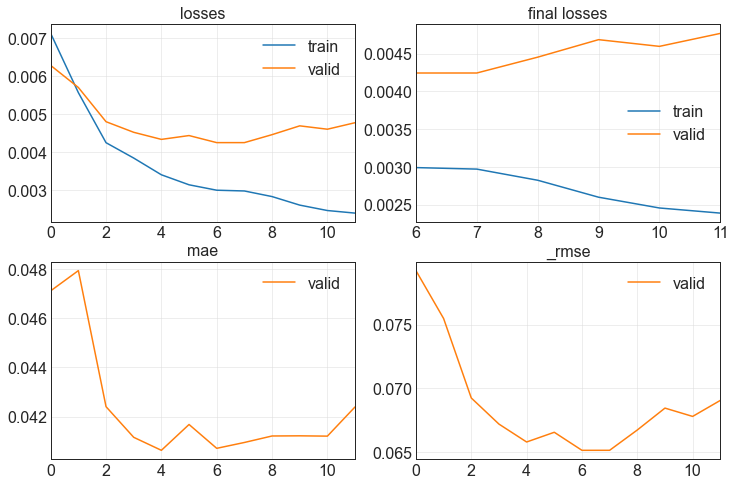

444.22092032432556                                                                                                     
[0.0023861860390752554, 0.004769344814121723, 0.04239309951663017, 0.06906045228242874]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 32%|████████████▍                          | 32/100 [3:19:39<6:04:08, 321.30s/trial, best loss: 0.0015792188933119178]

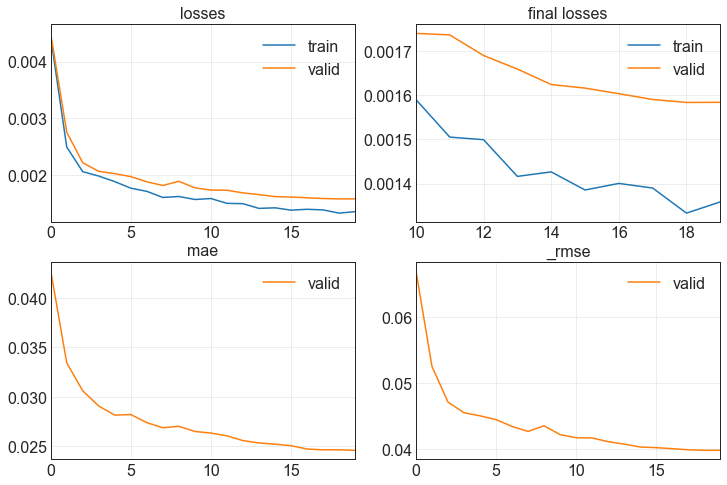

280.42525005340576                                                                                                     
[0.0013584443368017673, 0.0015835828380659223, 0.024599863216280937, 0.03979425132274628]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 33%|████████████▊                          | 33/100 [3:24:24<5:46:39, 310.44s/trial, best loss: 0.0015792188933119178]

No improvement since epoch 53: early stopping                                                                          
 33%|████████████▊                          | 33/100 [3:32:07<5:46:39, 310.44s/trial, best loss: 0.0015792188933119178]

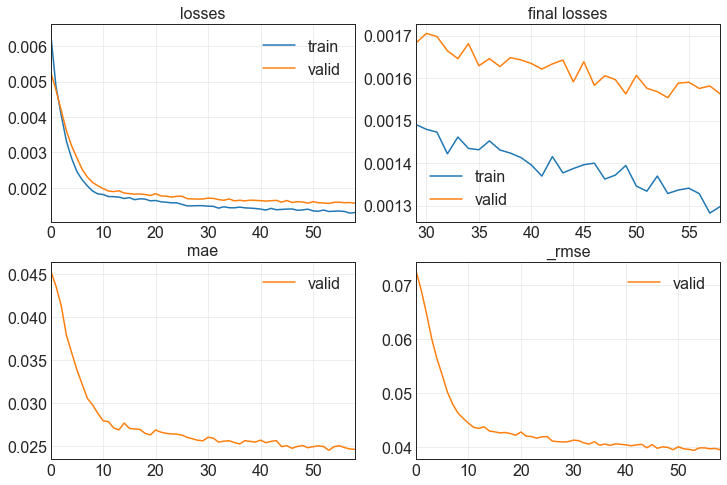

463.34533166885376                                                                                                     
[0.0012979035964235663, 0.0015627315733581781, 0.02465403825044632, 0.039531409740448]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 34%|█████████████▎                         | 34/100 [3:32:12<6:33:29, 357.72s/trial, best loss: 0.0015627315733581781]

No improvement since epoch 38: early stopping                                                                          
 34%|█████████████▎                         | 34/100 [3:36:49<6:33:29, 357.72s/trial, best loss: 0.0015627315733581781]

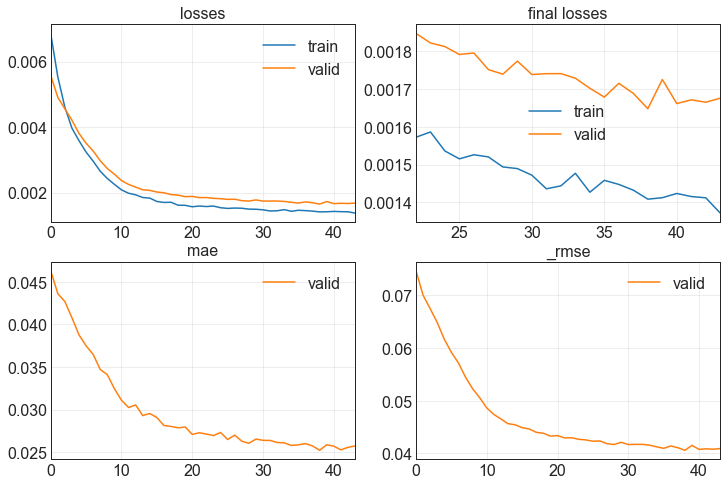

277.23739647865295                                                                                                     
[0.0013716549146920443, 0.0016756930854171515, 0.02572248876094818, 0.04093522951006889]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 35%|█████████████▋                         | 35/100 [3:36:55<6:02:58, 335.05s/trial, best loss: 0.0015627315733581781]

No improvement since epoch 34: early stopping                                                                          
 35%|█████████████▋                         | 35/100 [3:42:22<6:02:58, 335.05s/trial, best loss: 0.0015627315733581781]

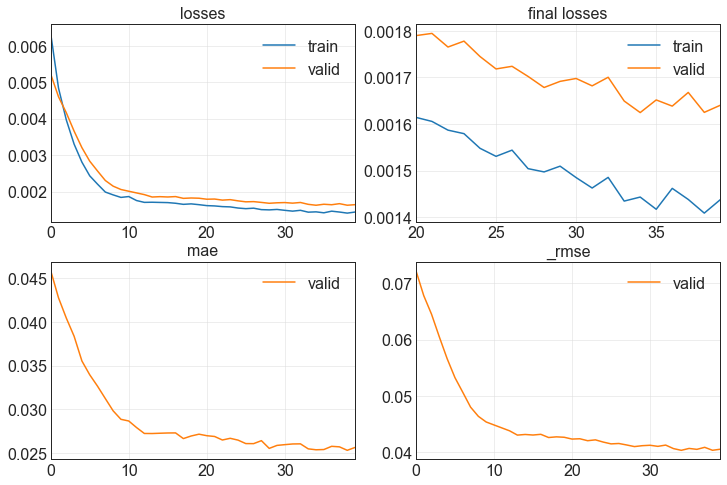

328.232608795166                                                                                                       
[0.0014375183964148164, 0.0016401935135945678, 0.02561083808541298, 0.040499307215213776]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 36%|██████████████                         | 36/100 [3:42:28<5:56:48, 334.51s/trial, best loss: 0.0015627315733581781]

No improvement since epoch 69: early stopping                                                                          
 36%|██████████████                         | 36/100 [3:49:57<5:56:48, 334.51s/trial, best loss: 0.0015627315733581781]

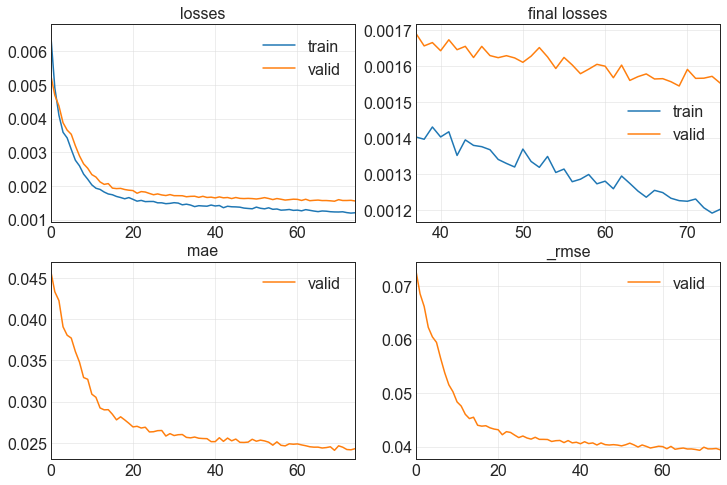

450.50100445747375                                                                                                     
[0.0012022440787404776, 0.0015525651397183537, 0.024288218468427658, 0.03940260782837868]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 37%|██████████████▍                        | 37/100 [3:50:03<6:29:15, 370.73s/trial, best loss: 0.0015525651397183537]

No improvement since epoch 54: early stopping                                                                          
 37%|██████████████▍                        | 37/100 [3:55:57<6:29:15, 370.73s/trial, best loss: 0.0015525651397183537]

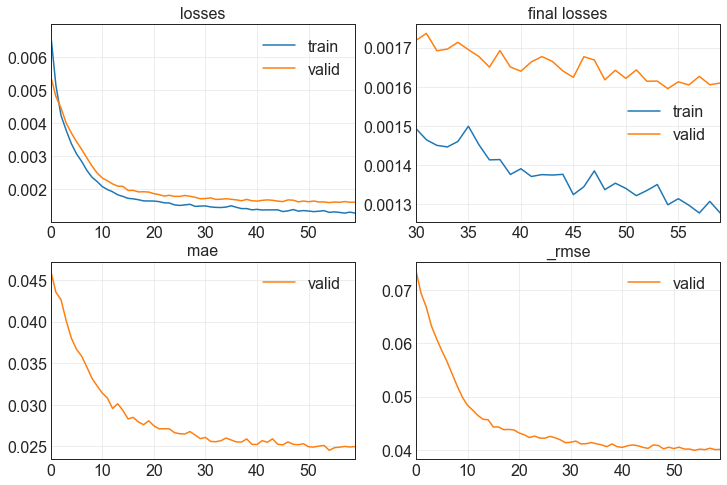

354.33050537109375                                                                                                     
[0.0012777319643646479, 0.001609808299690485, 0.02496907114982605, 0.040122419595718384]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 38%|██████████████▊                        | 38/100 [3:56:02<6:19:28, 367.24s/trial, best loss: 0.0015525651397183537]

No improvement since epoch 89: early stopping                                                                          
 38%|██████████████▊                        | 38/100 [4:05:49<6:19:28, 367.24s/trial, best loss: 0.0015525651397183537]

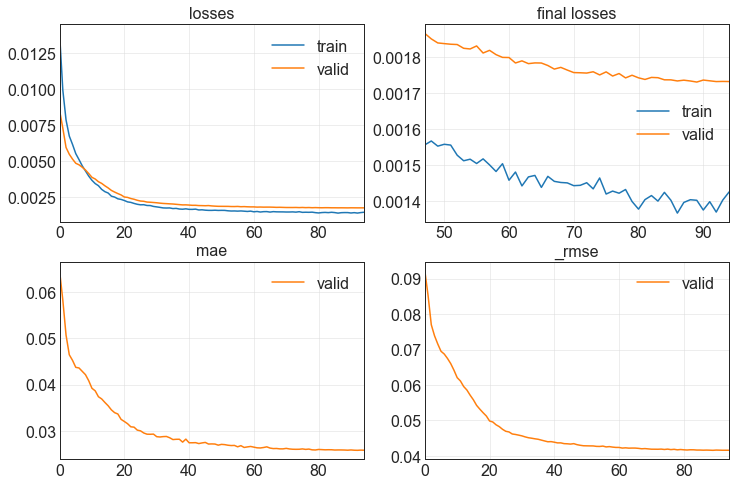

587.4069046974182                                                                                                      
[0.001425190712325275, 0.0017313818680122495, 0.025836298242211342, 0.04160987585783005]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 39%|███████████████▏                       | 39/100 [4:05:54<7:21:57, 434.71s/trial, best loss: 0.0015525651397183537]

No improvement since epoch 85: early stopping                                                                          
 39%|███████████████▏                       | 39/100 [4:15:29<7:21:57, 434.71s/trial, best loss: 0.0015525651397183537]

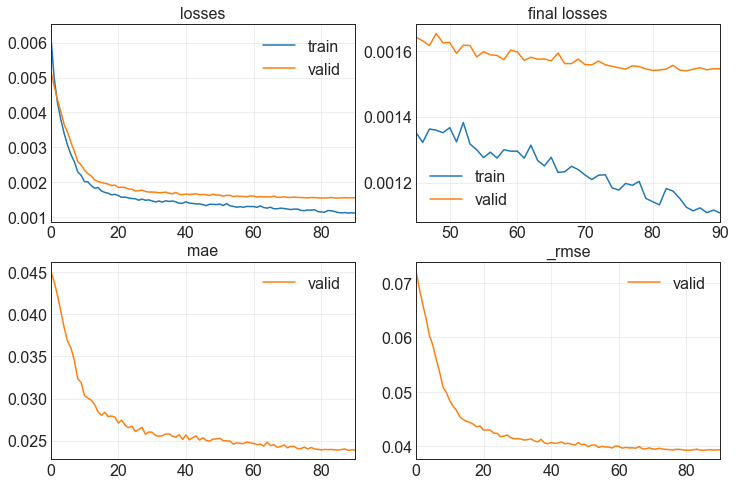

575.2588064670563                                                                                                      
[0.0011071666376665235, 0.0015454645035788417, 0.02389971725642681, 0.03931240364909172]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 40%|███████████████▌                       | 40/100 [4:15:34<7:58:22, 478.37s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 6: early stopping                                                                           
 40%|███████████████▌                       | 40/100 [4:18:03<7:58:22, 478.37s/trial, best loss: 0.0015454645035788417]

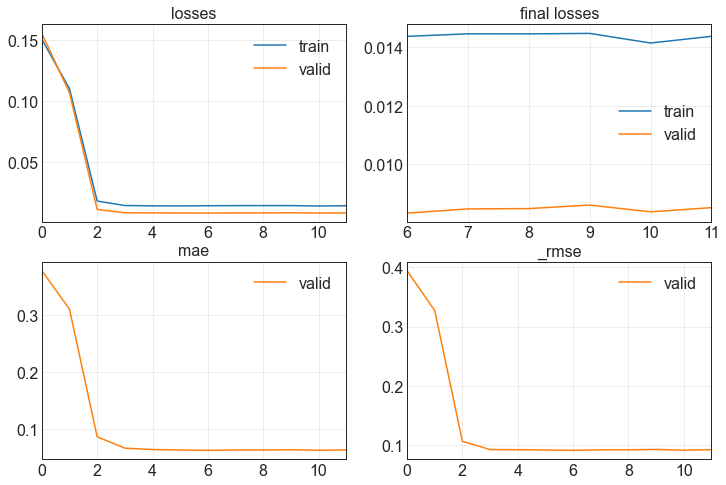

149.59683442115784                                                                                                     
[0.01437618862837553, 0.00851590558886528, 0.06332453340291977, 0.09228167682886124]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 41%|███████████████▉                       | 41/100 [4:18:09<6:14:48, 381.17s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 18: early stopping                                                                          
 41%|███████████████▉                       | 41/100 [4:22:36<6:14:48, 381.17s/trial, best loss: 0.0015454645035788417]

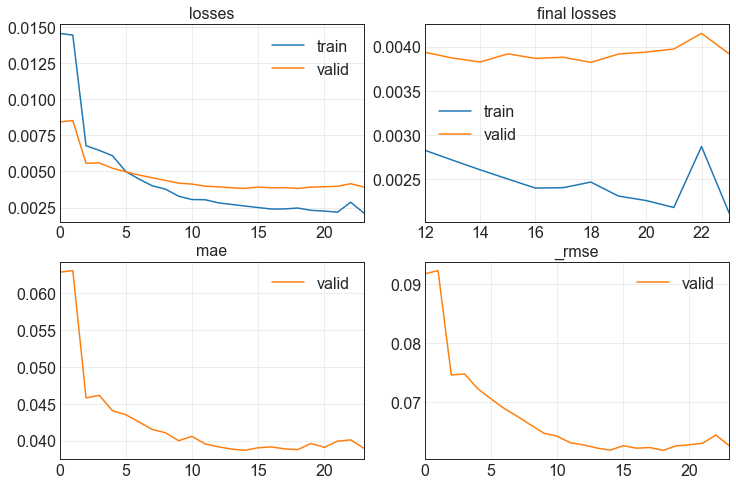

267.8036301136017                                                                                                      
[0.002118439646437764, 0.003919715061783791, 0.038965336978435516, 0.06260763108730316]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 42%|████████████████▍                      | 42/100 [4:22:41<5:36:56, 348.56s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 94: early stopping                                                                          
 42%|████████████████▍                      | 42/100 [4:35:17<5:36:56, 348.56s/trial, best loss: 0.0015454645035788417]

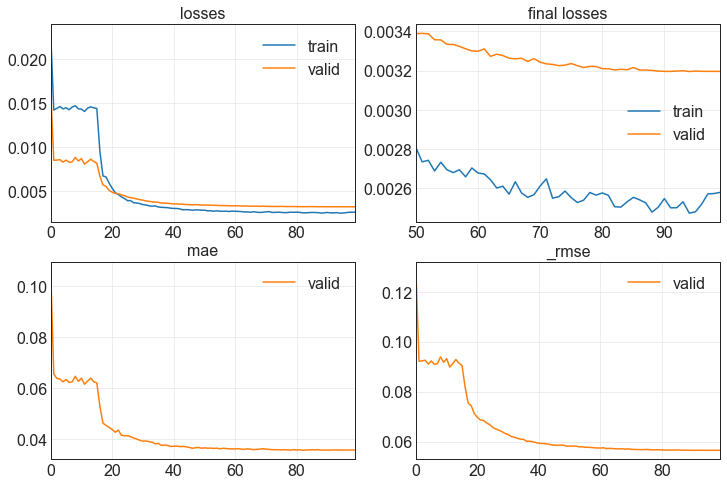

756.4509229660034                                                                                                      
[0.0025782291777431965, 0.0031960667110979557, 0.0358777679502964, 0.05653377249836922]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 43%|████████████████▊                      | 43/100 [4:35:22<7:28:45, 472.38s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 88: early stopping                                                                          
 43%|████████████████▊                      | 43/100 [4:40:16<7:28:45, 472.38s/trial, best loss: 0.0015454645035788417]

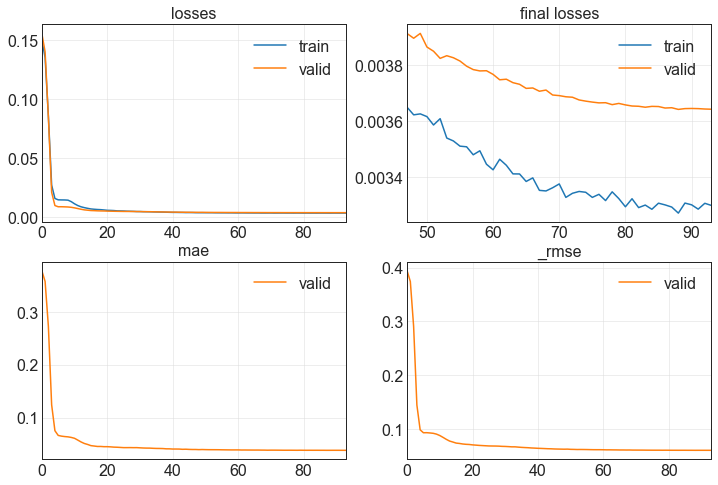

293.62232208251953                                                                                                     
[0.0033000148832798004, 0.0036437436938285828, 0.03815571218729019, 0.06036343052983284]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 44%|█████████████████▏                     | 44/100 [4:40:21<6:32:09, 420.16s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 56: early stopping                                                                          
 44%|█████████████████▏                     | 44/100 [4:46:39<6:32:09, 420.16s/trial, best loss: 0.0015454645035788417]

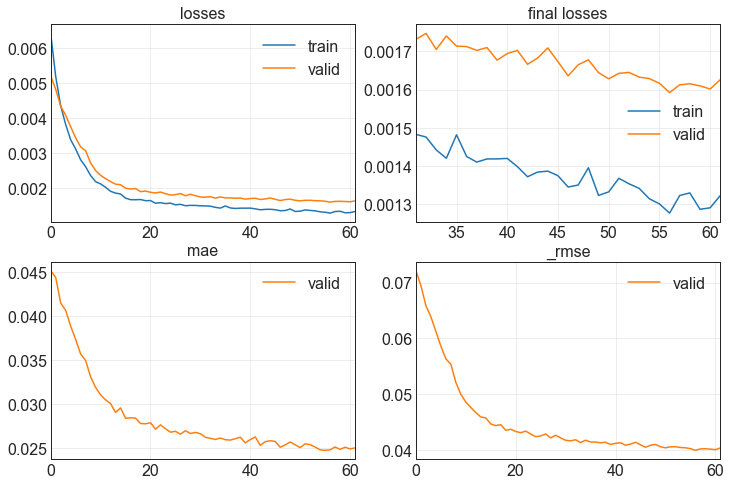

378.8468441963196                                                                                                      
[0.0013234603684395552, 0.0016260052798315883, 0.024999966844916344, 0.04032374918460846]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 45%|█████████████████▌                     | 45/100 [4:46:45<6:15:04, 409.18s/trial, best loss: 0.0015454645035788417]

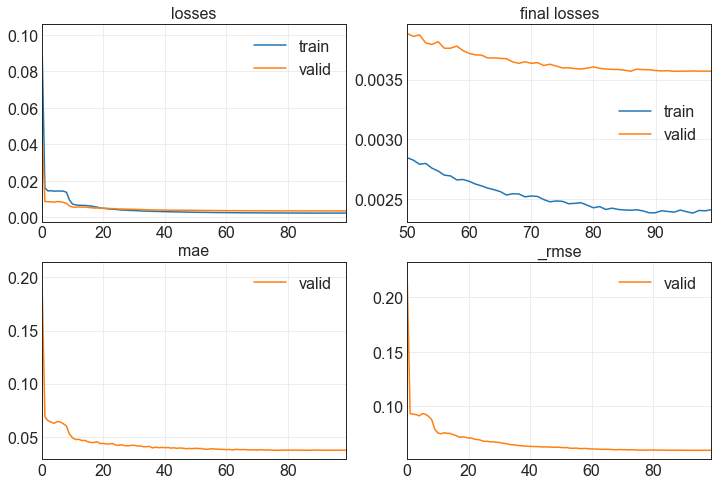

315.4815390110016                                                                                                      
[0.0024086860939860344, 0.003571697510778904, 0.037386562675237656, 0.05976368114352226]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 46%|█████████████████▉                     | 46/100 [4:52:05<5:44:18, 382.57s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 31: early stopping                                                                          
 46%|█████████████████▉                     | 46/100 [4:56:44<5:44:18, 382.57s/trial, best loss: 0.0015454645035788417]

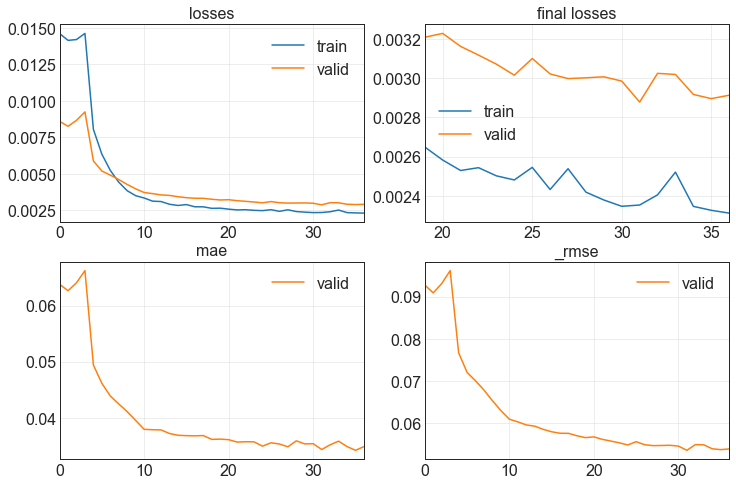

279.3460874557495                                                                                                      
[0.002311303047463298, 0.0029136959929019213, 0.03486834093928337, 0.05397866293787956]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 47%|██████████████████▎                    | 47/100 [4:56:49<5:11:53, 353.08s/trial, best loss: 0.0015454645035788417]

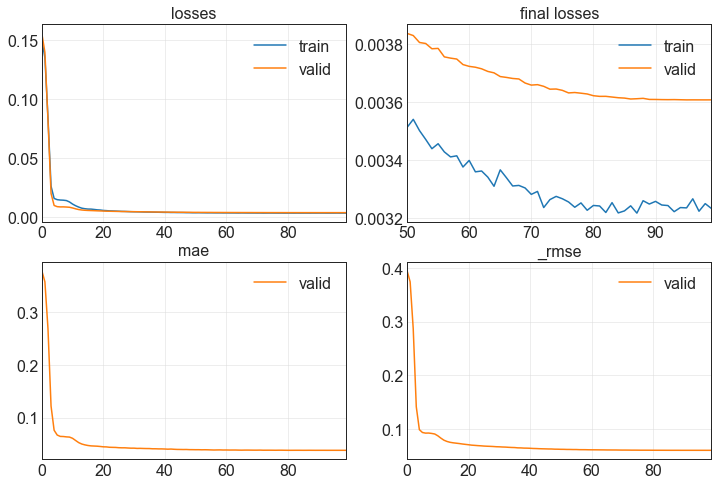

313.20989775657654                                                                                                     
[0.0032340693287551403, 0.0036088728811591864, 0.03791998699307442, 0.06007390469312668]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 48%|██████████████████▋                    | 48/100 [5:02:07<4:56:51, 342.53s/trial, best loss: 0.0015454645035788417]

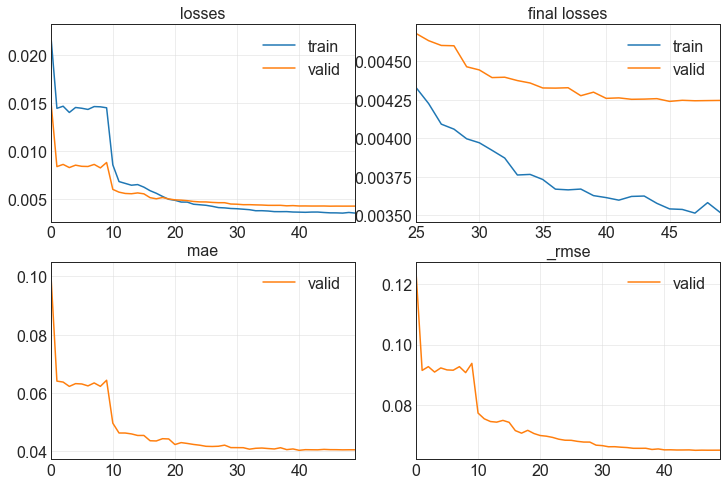

477.889639377594                                                                                                       
[0.003518420737236738, 0.0042453911155462265, 0.04053705930709839, 0.06515666097402573]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 49%|███████████████████                    | 49/100 [5:10:10<5:26:52, 384.56s/trial, best loss: 0.0015454645035788417]

No improvement since epoch 89: early stopping                                                                          
 49%|███████████████████                    | 49/100 [5:20:03<5:26:52, 384.56s/trial, best loss: 0.0015454645035788417]

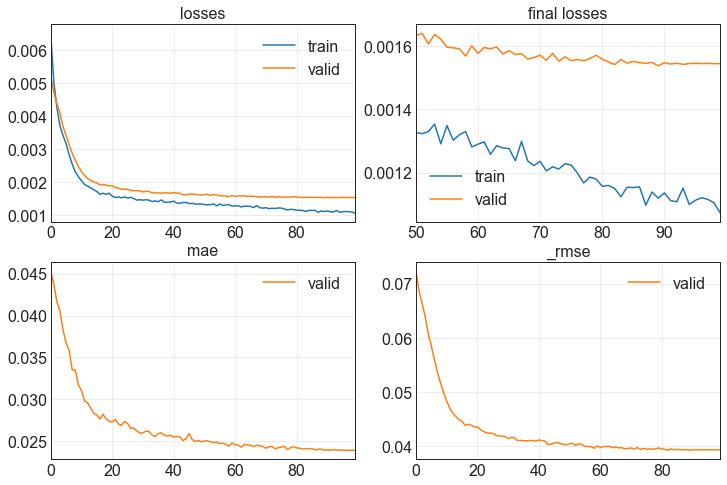

593.78284907341                                                                                                        
[0.0010722820879891515, 0.0015439999988302588, 0.02391090802848339, 0.03929376229643822]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 50%|███████████████████▌                   | 50/100 [5:20:08<6:14:00, 448.80s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 17: early stopping                                                                          
 50%|███████████████████▌                   | 50/100 [5:21:36<6:14:00, 448.80s/trial, best loss: 0.0015439999988302588]

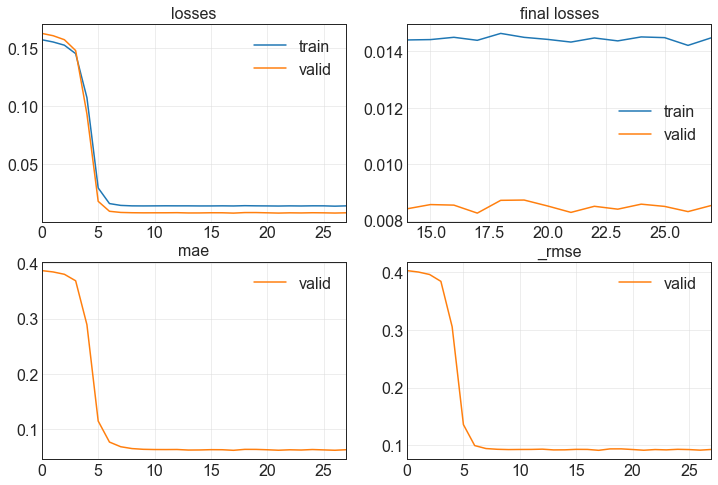

88.44789290428162                                                                                                      
[0.0144874956458807, 0.00853736698627472, 0.06348753720521927, 0.09239786863327026]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 51%|███████████████████▉                   | 51/100 [5:21:41<4:39:23, 342.11s/trial, best loss: 0.0015439999988302588]

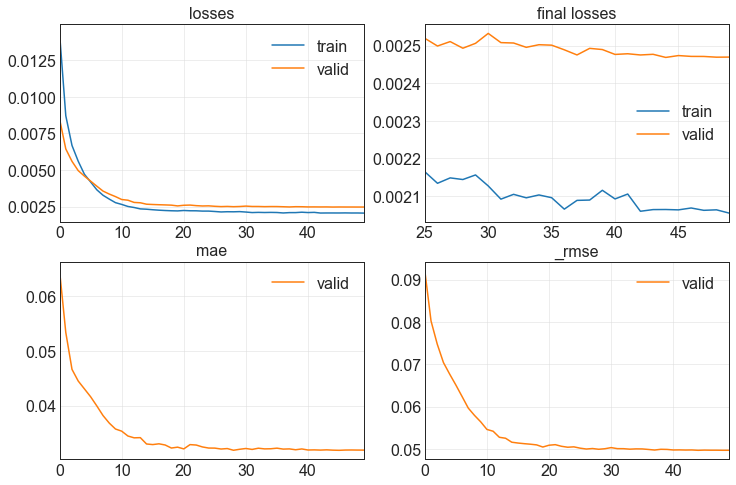

138.87952065467834                                                                                                     
[0.002054160227999091, 0.0024695906322449446, 0.03187474235892296, 0.0496949777007103]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 52%|████████████████████▎                  | 52/100 [5:24:05<3:46:03, 282.58s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 88: early stopping                                                                          
 52%|████████████████████▎                  | 52/100 [5:39:24<3:46:03, 282.58s/trial, best loss: 0.0015439999988302588]

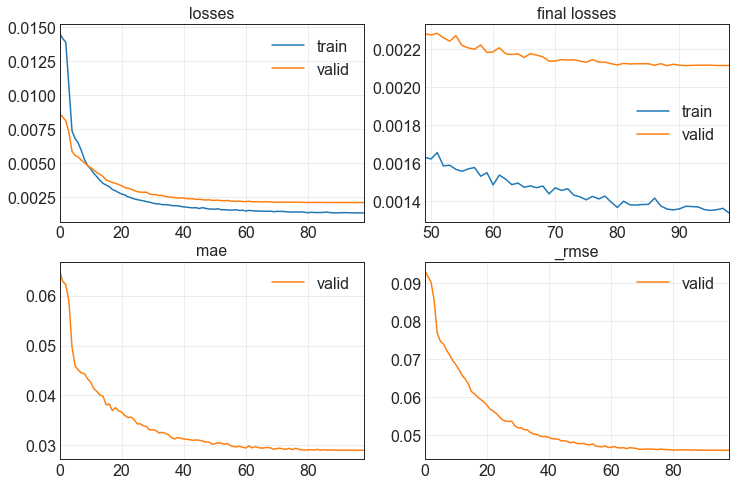

919.5657806396484                                                                                                      
[0.0013361378805711865, 0.002114304108545184, 0.029040204361081123, 0.04598155990242958]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 53%|████████████████████▋                  | 53/100 [5:39:30<6:12:10, 475.12s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 20: early stopping                                                                          
 53%|████████████████████▋                  | 53/100 [5:44:28<6:12:10, 475.12s/trial, best loss: 0.0015439999988302588]

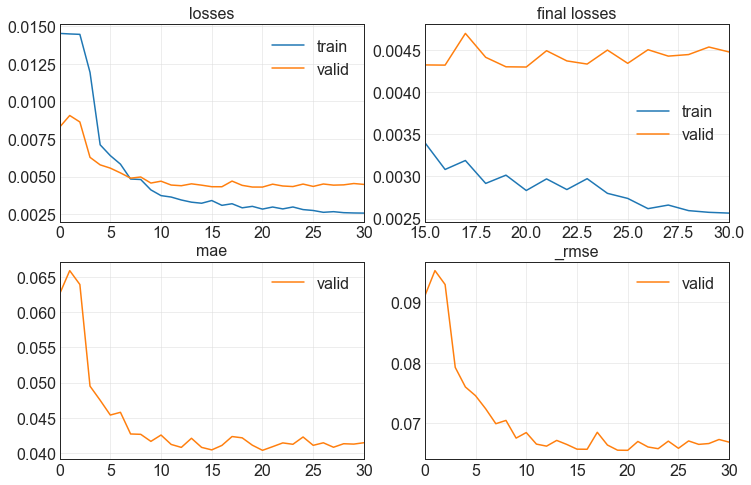

298.57060647010803                                                                                                     
[0.002565509406849742, 0.004475691355764866, 0.04149073362350464, 0.06690060347318649]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 54%|█████████████████████                  | 54/100 [5:44:33<5:24:45, 423.60s/trial, best loss: 0.0015439999988302588]

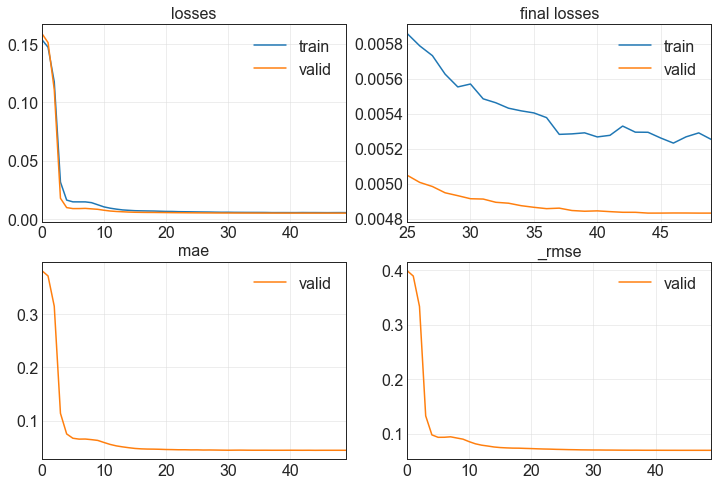

84.26002287864685                                                                                                      
[0.005251414608210325, 0.0048310826532542706, 0.04420801252126694, 0.06950598955154419]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 55%|█████████████████████▍                 | 55/100 [5:46:02<4:02:25, 323.22s/trial, best loss: 0.0015439999988302588]

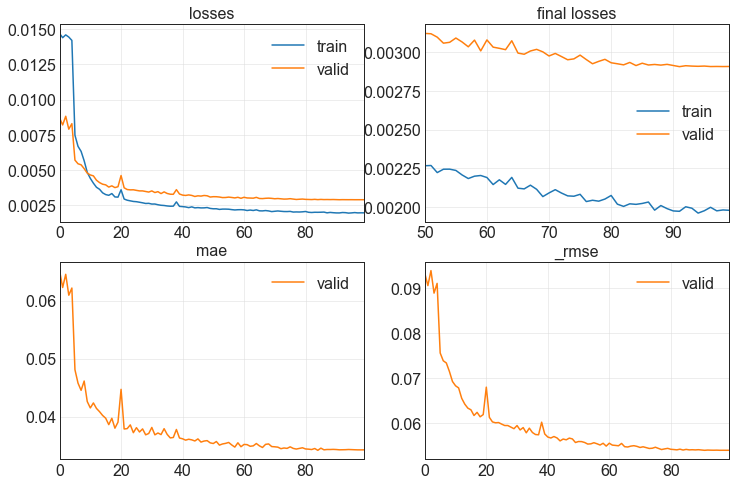

444.19104075431824                                                                                                     
[0.0019783000461757183, 0.002909247064962983, 0.03428814187645912, 0.05393742769956589]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 56%|█████████████████████▊                 | 56/100 [5:53:31<4:24:39, 360.91s/trial, best loss: 0.0015439999988302588]

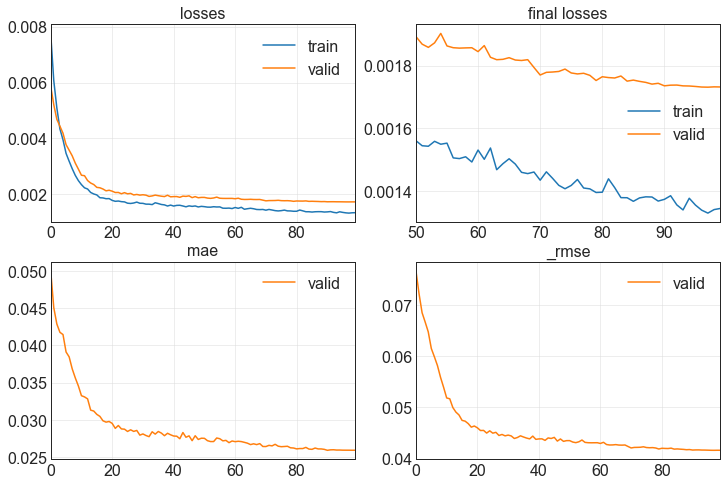

555.1057825088501                                                                                                      
[0.001345382072031498, 0.0017319280887022614, 0.025904348120093346, 0.041616443544626236]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 57%|██████████████████████▏                | 57/100 [6:02:51<5:01:25, 420.58s/trial, best loss: 0.0015439999988302588]

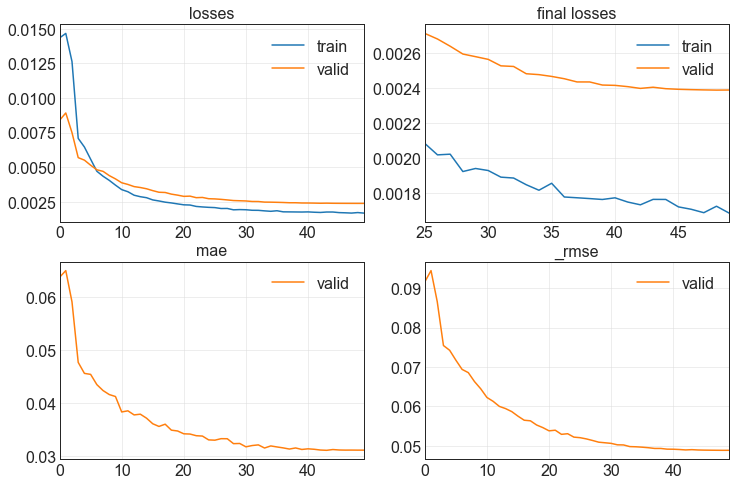

470.7232985496521                                                                                                      
[0.0016872478881850839, 0.002389264525845647, 0.03111693076789379, 0.048880111426115036]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 58%|██████████████████████▌                | 58/100 [6:10:46<5:05:56, 437.06s/trial, best loss: 0.0015439999988302588]

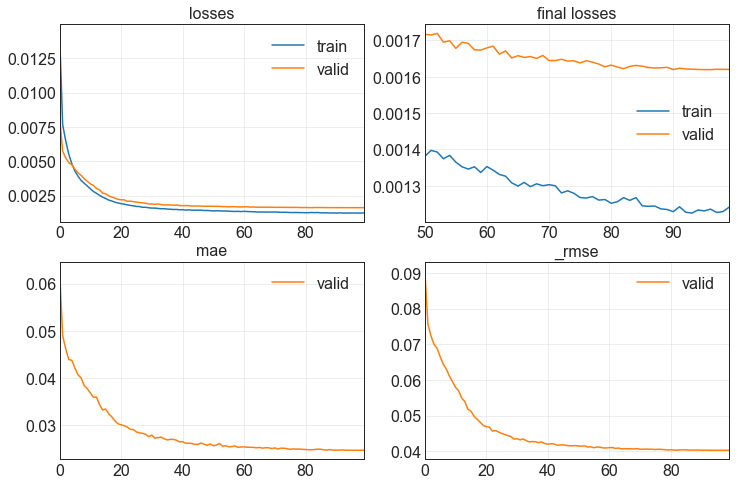

167.35795664787292                                                                                                     
[0.0012413165532052517, 0.0016202395781874657, 0.024706130847334862, 0.0402522012591362]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 59%|███████████████████████                | 59/100 [6:13:38<4:04:21, 357.59s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 16: early stopping                                                                          
 59%|███████████████████████                | 59/100 [6:18:06<4:04:21, 357.59s/trial, best loss: 0.0015439999988302588]

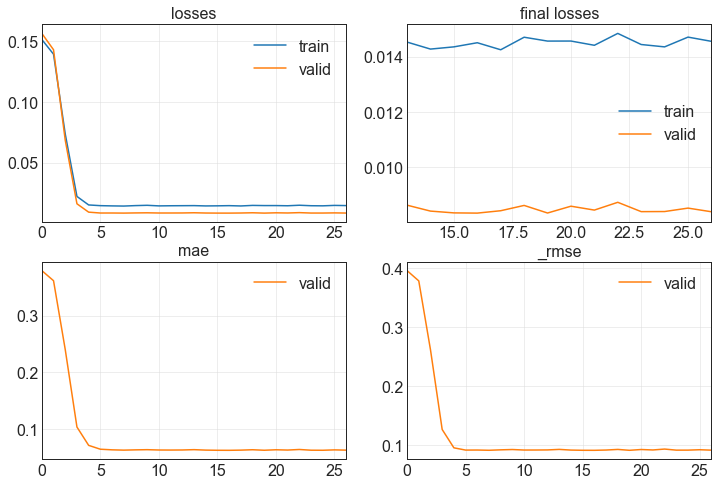

267.69368171691895                                                                                                     
[0.014552704058587551, 0.008395921438932419, 0.06294354051351547, 0.0916292741894722]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 60%|███████████████████████▍               | 60/100 [6:18:11<3:41:23, 332.08s/trial, best loss: 0.0015439999988302588]

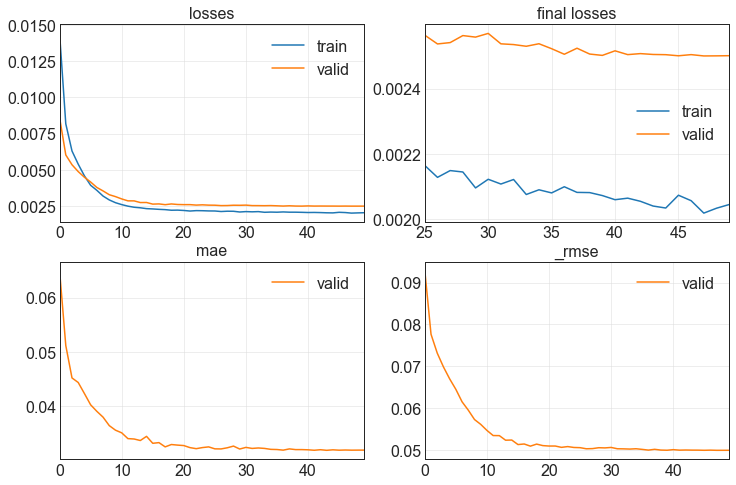

138.63364028930664                                                                                                     
[0.0020449392031878233, 0.002500976901501417, 0.031859029084444046, 0.050009772181510925]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 61%|███████████████████████▊               | 61/100 [6:20:34<2:59:02, 275.46s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 83: early stopping                                                                          
 61%|███████████████████████▊               | 61/100 [6:32:55<2:59:02, 275.46s/trial, best loss: 0.0015439999988302588]

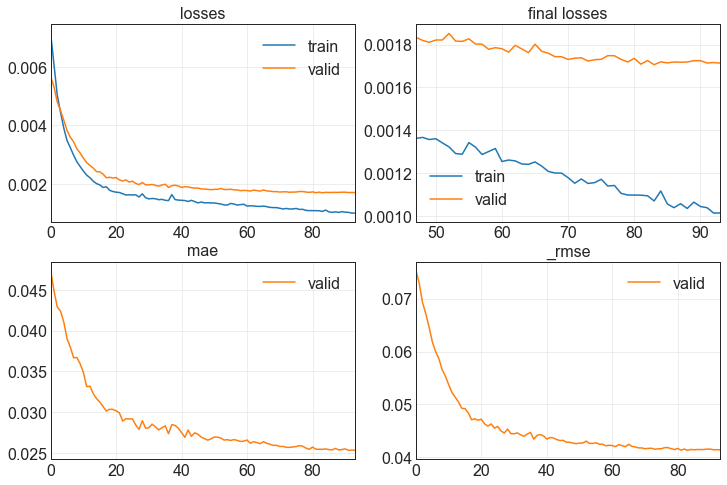

740.8814153671265                                                                                                      
[0.0010134070180356503, 0.0017138364491984248, 0.025321343913674355, 0.041398510336875916]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 62%|████████████████████████▏              | 62/100 [6:33:00<4:23:46, 416.50s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 12: early stopping                                                                          
 62%|████████████████████████▏              | 62/100 [6:37:22<4:23:46, 416.50s/trial, best loss: 0.0015439999988302588]

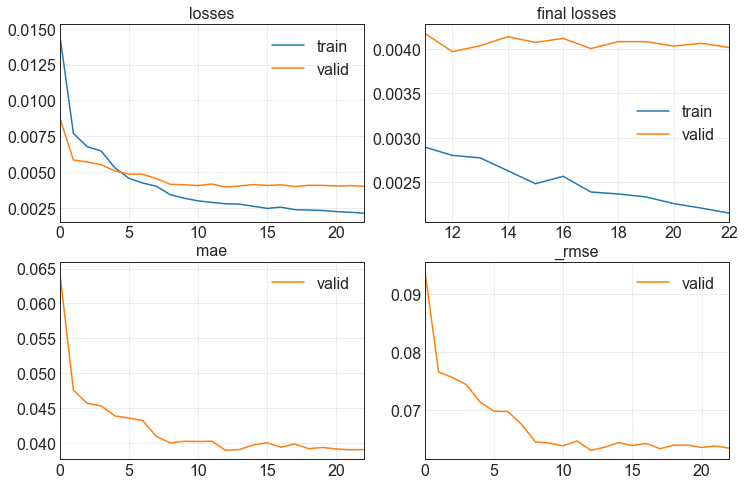

262.53996205329895                                                                                                     
[0.002149814972653985, 0.004017976112663746, 0.03908674791455269, 0.06338749825954437]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 63%|████████████████████████▌              | 63/100 [6:37:27<3:49:17, 371.82s/trial, best loss: 0.0015439999988302588]

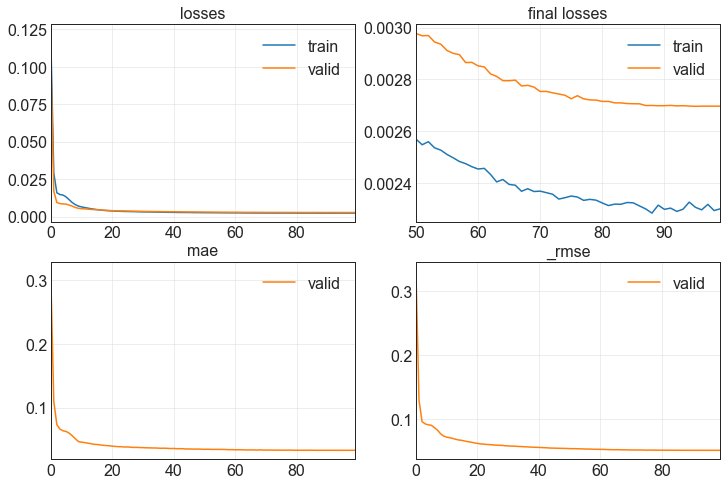

166.7757647037506                                                                                                      
[0.0023004324175417423, 0.002696822164580226, 0.03324764221906662, 0.05193094164133072]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 64%|████████████████████████▉              | 64/100 [6:40:19<3:07:03, 311.77s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 38: early stopping                                                                          
 64%|████████████████████████▉              | 64/100 [6:48:07<3:07:03, 311.77s/trial, best loss: 0.0015439999988302588]

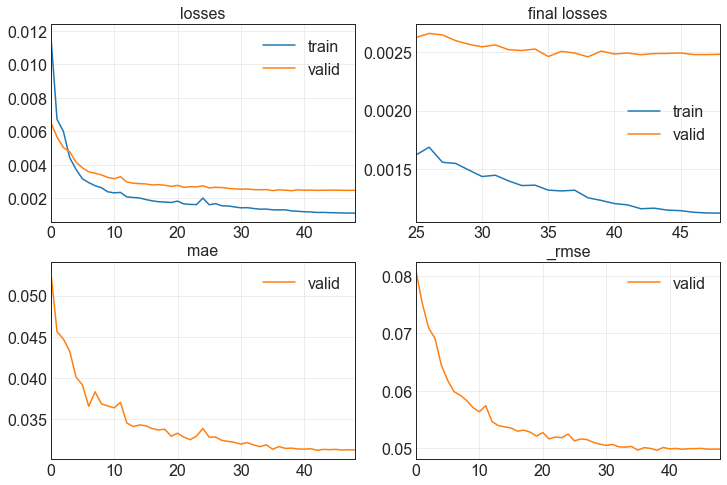

468.5364329814911                                                                                                      
[0.0011224037734791636, 0.002482954179868102, 0.03125448524951935, 0.049829255789518356]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 65%|█████████████████████████▎             | 65/100 [6:48:12<3:30:07, 360.21s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 49: early stopping                                                                          
 65%|█████████████████████████▎             | 65/100 [6:53:53<3:30:07, 360.21s/trial, best loss: 0.0015439999988302588]

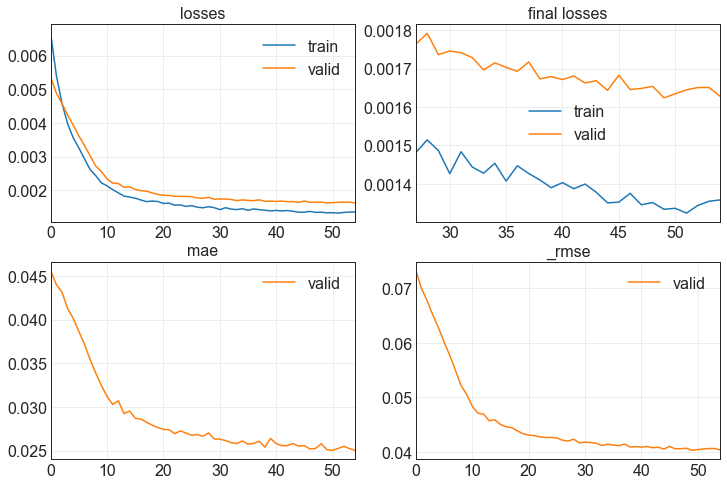

341.2308475971222                                                                                                      
[0.0013582640094682574, 0.0016272702487185597, 0.025044875219464302, 0.04033943638205528]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 66%|█████████████████████████▋             | 66/100 [6:53:58<3:21:43, 355.98s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 31: early stopping                                                                          
 66%|█████████████████████████▋             | 66/100 [6:57:36<3:21:43, 355.98s/trial, best loss: 0.0015439999988302588]

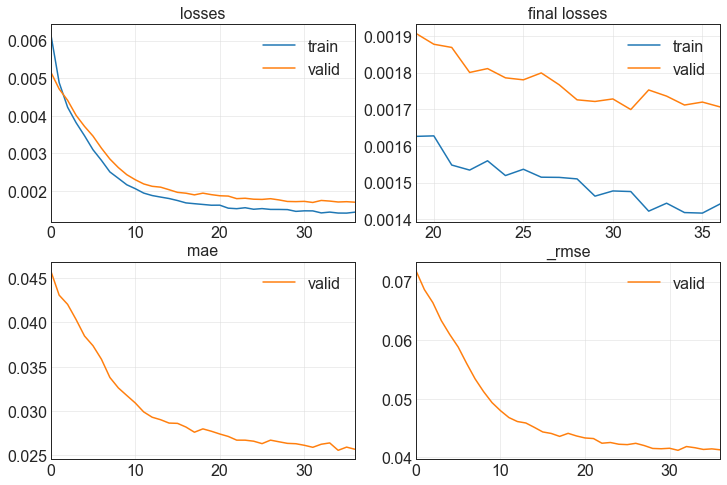

217.72904443740845                                                                                                     
[0.001441824366338551, 0.0017061810940504074, 0.025677110999822617, 0.041305944323539734]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 67%|██████████████████████████▏            | 67/100 [6:57:41<2:53:45, 315.93s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 46: early stopping                                                                          
 67%|██████████████████████████▏            | 67/100 [7:02:54<2:53:45, 315.93s/trial, best loss: 0.0015439999988302588]

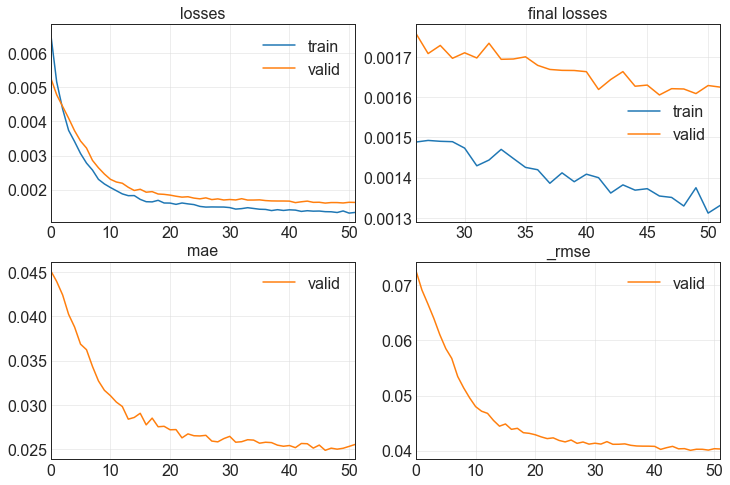

313.7595570087433                                                                                                      
[0.0013309081550687551, 0.0016246628947556019, 0.025561392307281494, 0.04030711576342583]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 68%|██████████████████████████▌            | 68/100 [7:03:00<2:48:55, 316.75s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 50: early stopping                                                                          
 68%|██████████████████████████▌            | 68/100 [7:08:44<2:48:55, 316.75s/trial, best loss: 0.0015439999988302588]

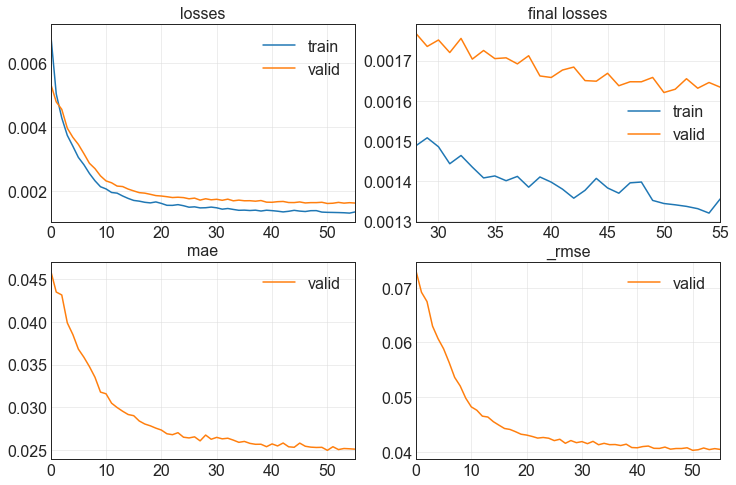

344.5776791572571                                                                                                      
[0.0013564064865931869, 0.001634041196666658, 0.025103943422436714, 0.040423281490802765]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 69%|██████████████████████████▉            | 69/100 [7:08:49<2:48:46, 326.67s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 47: early stopping                                                                          
 69%|██████████████████████████▉            | 69/100 [7:14:22<2:48:46, 326.67s/trial, best loss: 0.0015439999988302588]

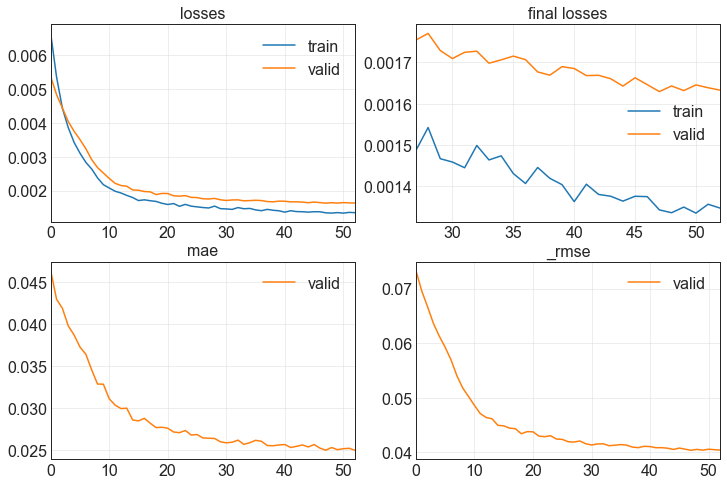

332.9071989059448                                                                                                      
[0.00134753726888448, 0.0016329663340002298, 0.024944761767983437, 0.040409982204437256]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 70%|███████████████████████████▎           | 70/100 [7:14:27<2:44:59, 329.97s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 45: early stopping                                                                          
 70%|███████████████████████████▎           | 70/100 [7:19:26<2:44:59, 329.97s/trial, best loss: 0.0015439999988302588]

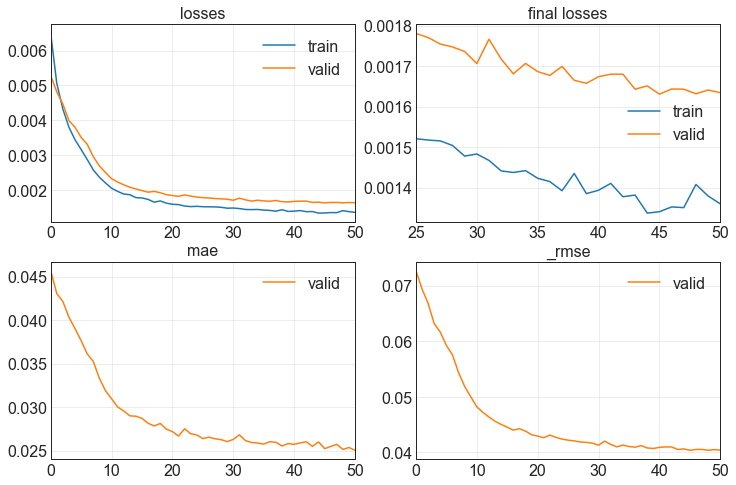

299.2218813896179                                                                                                      
[0.0013601155951619148, 0.0016345614567399025, 0.02502552792429924, 0.040429700165987015]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 71%|███████████████████████████▋           | 71/100 [7:19:31<2:35:43, 322.18s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 49: early stopping                                                                          
 71%|███████████████████████████▋           | 71/100 [7:24:52<2:35:43, 322.18s/trial, best loss: 0.0015439999988302588]

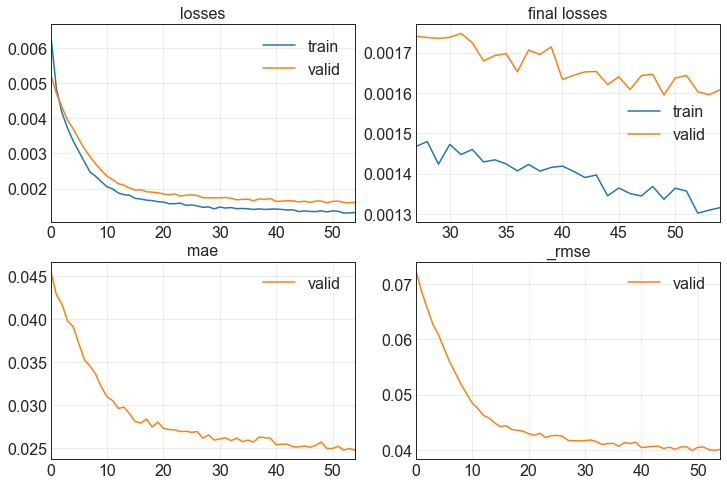

321.707617521286                                                                                                       
[0.0013154837070032954, 0.0016078404150903225, 0.024717893451452255, 0.04009788855910301]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 72%|████████████████████████████           | 72/100 [7:24:57<2:30:56, 323.45s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 38: early stopping                                                                          
 72%|████████████████████████████           | 72/100 [7:30:30<2:30:56, 323.45s/trial, best loss: 0.0015439999988302588]

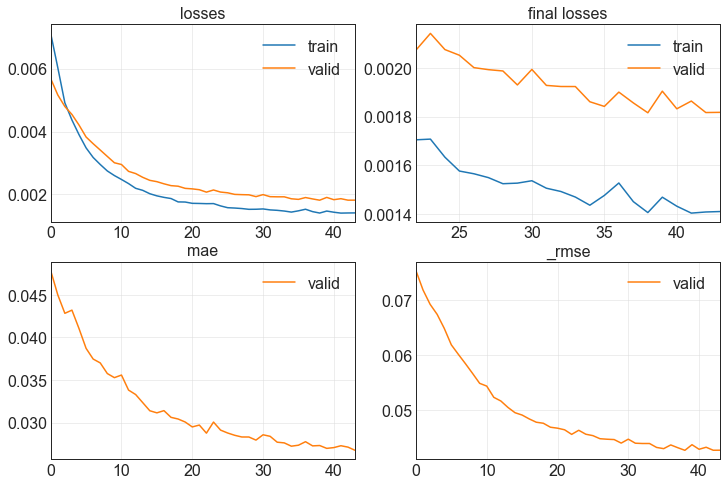

333.2189087867737                                                                                                      
[0.0014114956138655543, 0.0018176117446273565, 0.026747694239020348, 0.04263346642255783]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 73%|████████████████████████████▍          | 73/100 [7:30:35<2:27:30, 327.79s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 56: early stopping                                                                          
 73%|████████████████████████████▍          | 73/100 [7:33:44<2:27:30, 327.79s/trial, best loss: 0.0015439999988302588]

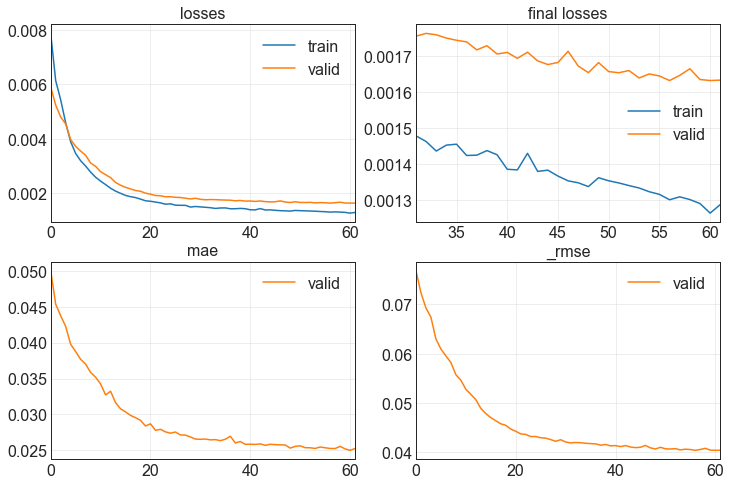

189.61057353019714                                                                                                     
[0.0012881506700068712, 0.0016334831016138196, 0.02522909641265869, 0.04041636735200882]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 74%|████████████████████████████▊          | 74/100 [7:33:49<2:04:41, 287.74s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 67: early stopping                                                                          
 74%|████████████████████████████▊          | 74/100 [7:41:03<2:04:41, 287.74s/trial, best loss: 0.0015439999988302588]

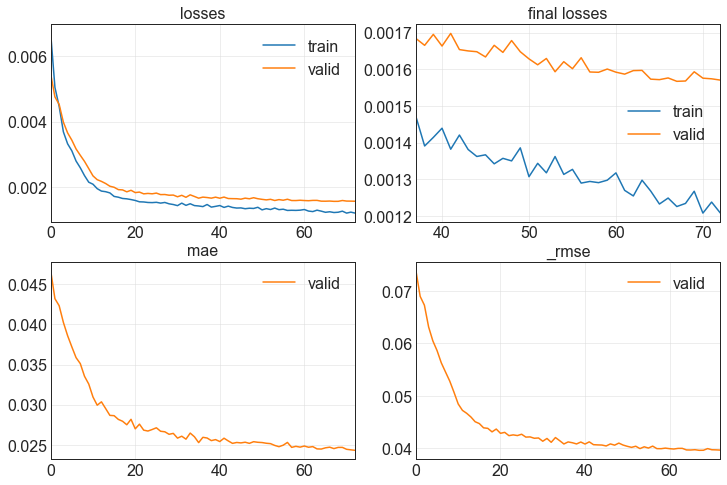

434.283438205719                                                                                                       
[0.0012087458744645119, 0.0015704474644735456, 0.024312088266015053, 0.03962887451052666]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 75%|█████████████████████████████▎         | 75/100 [7:41:08<2:18:47, 333.10s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 13: early stopping                                                                          
 75%|█████████████████████████████▎         | 75/100 [7:45:11<2:18:47, 333.10s/trial, best loss: 0.0015439999988302588]

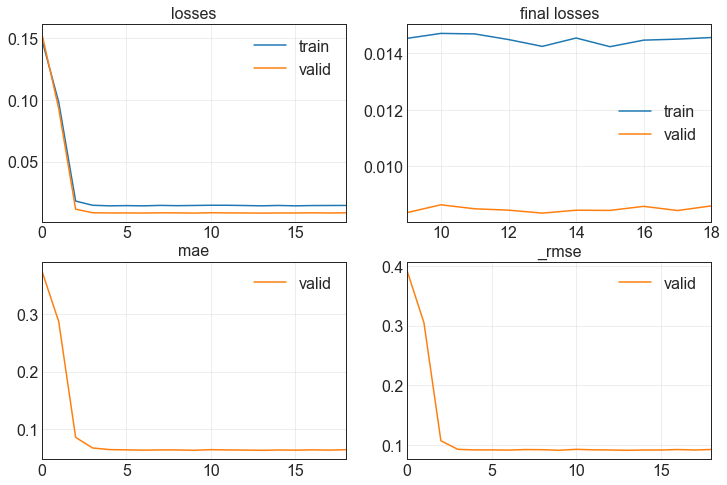

242.58303880691528                                                                                                     
[0.014561326242983341, 0.008604798465967178, 0.06376378983259201, 0.0927620455622673]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 76%|█████████████████████████████▋         | 76/100 [7:45:16<2:02:57, 307.38s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 29: early stopping                                                                          
 76%|█████████████████████████████▋         | 76/100 [7:48:20<2:02:57, 307.38s/trial, best loss: 0.0015439999988302588]

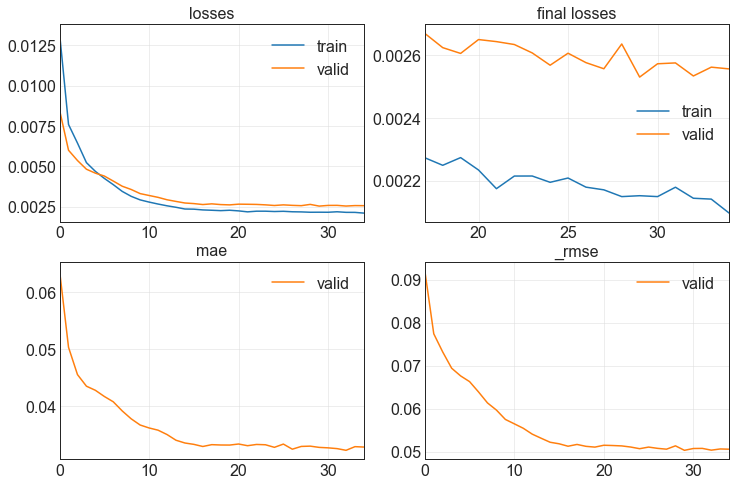

184.946702003479                                                                                                       
[0.0020959971006959677, 0.0025564455427229404, 0.03280983120203018, 0.05056130513548851]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 77%|██████████████████████████████         | 77/100 [7:48:26<1:44:17, 272.06s/trial, best loss: 0.0015439999988302588]

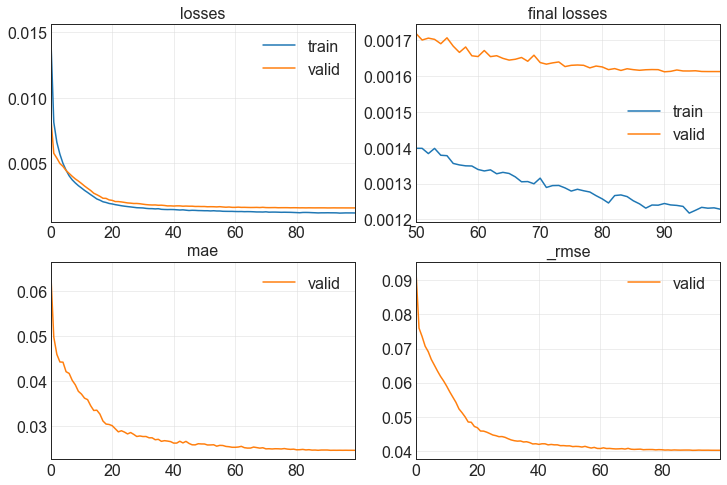

168.58852577209473                                                                                                     
[0.001228631124831736, 0.0016128960996866226, 0.024697978049516678, 0.040160879492759705]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 78%|██████████████████████████████▍        | 78/100 [7:51:19<1:28:53, 242.45s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 15: early stopping                                                                          
 78%|██████████████████████████████▍        | 78/100 [7:54:21<1:28:53, 242.45s/trial, best loss: 0.0015439999988302588]

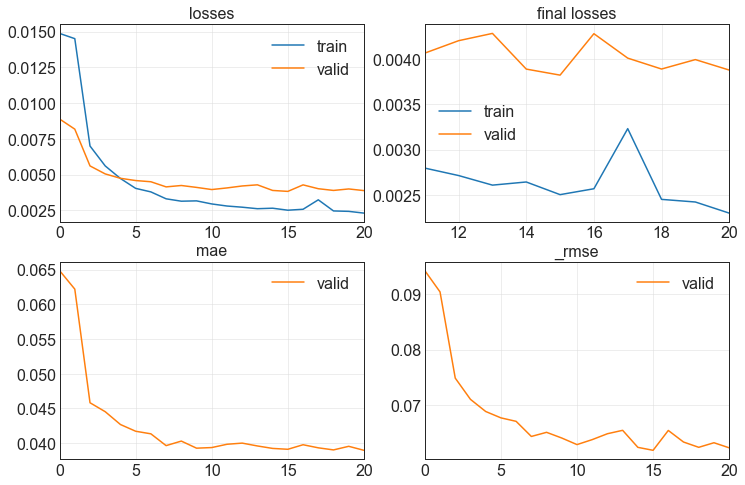

182.79311323165894                                                                                                     
[0.002301209606230259, 0.003876488422974944, 0.03896316885948181, 0.06226145103573799]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 79%|██████████████████████████████▊        | 79/100 [7:54:27<1:19:06, 226.04s/trial, best loss: 0.0015439999988302588]

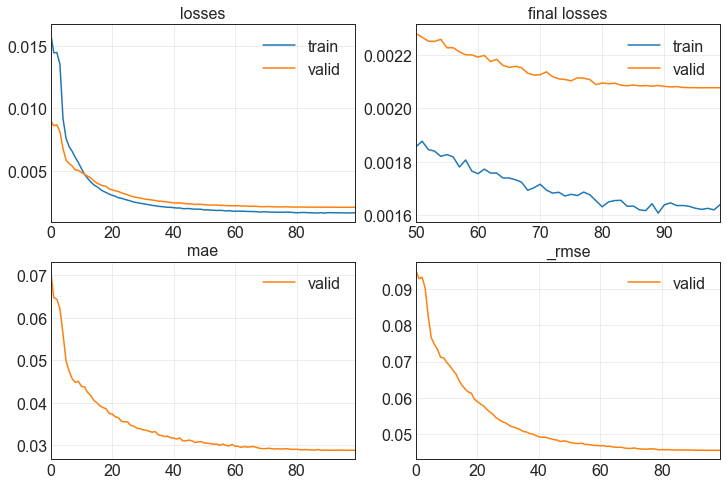

409.28120946884155                                                                                                     
[0.0016414844430983067, 0.0020771014969795942, 0.028820622712373734, 0.045575231313705444]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 80%|███████████████████████████████▏       | 80/100 [8:01:21<1:34:08, 282.42s/trial, best loss: 0.0015439999988302588]

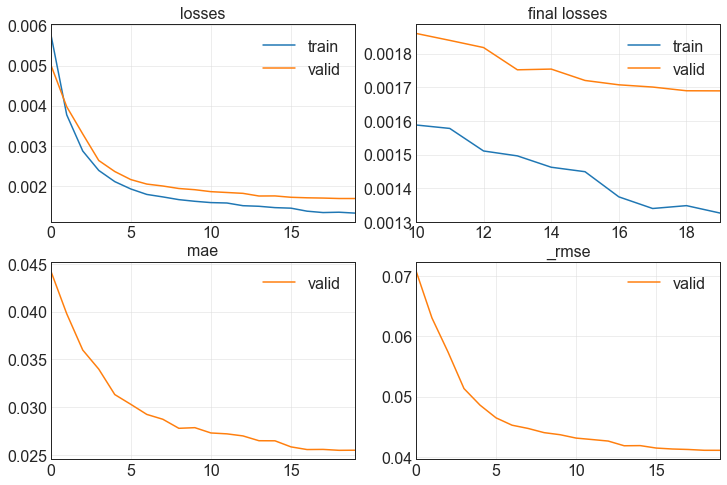

118.71107411384583                                                                                                     
[0.0013259182451292872, 0.0016891398699954152, 0.025503164157271385, 0.041099146008491516]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 81%|███████████████████████████████▌       | 81/100 [8:03:24<1:14:21, 234.83s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 93: early stopping                                                                          
 81%|███████████████████████████████▌       | 81/100 [8:19:02<1:14:21, 234.83s/trial, best loss: 0.0015439999988302588]

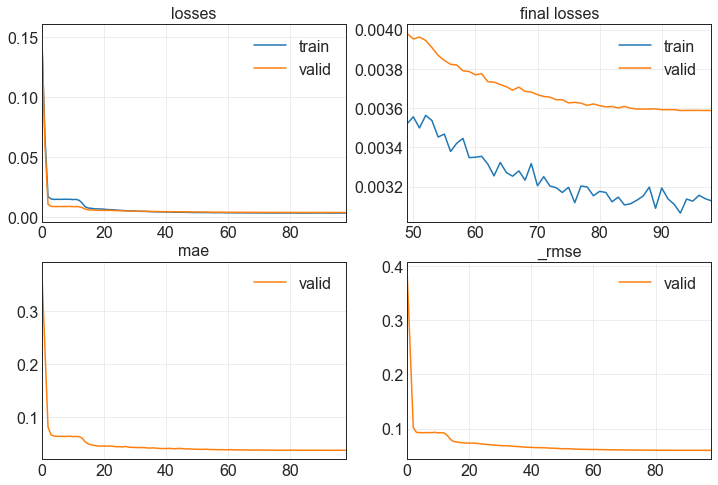

937.9087855815887                                                                                                      
[0.003126854542642832, 0.003587998216971755, 0.03747740387916565, 0.059899888932704926]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 82%|███████████████████████████████▉       | 82/100 [8:19:07<2:14:08, 447.16s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 22: early stopping                                                                          
 82%|███████████████████████████████▉       | 82/100 [8:34:18<2:14:08, 447.16s/trial, best loss: 0.0015439999988302588]

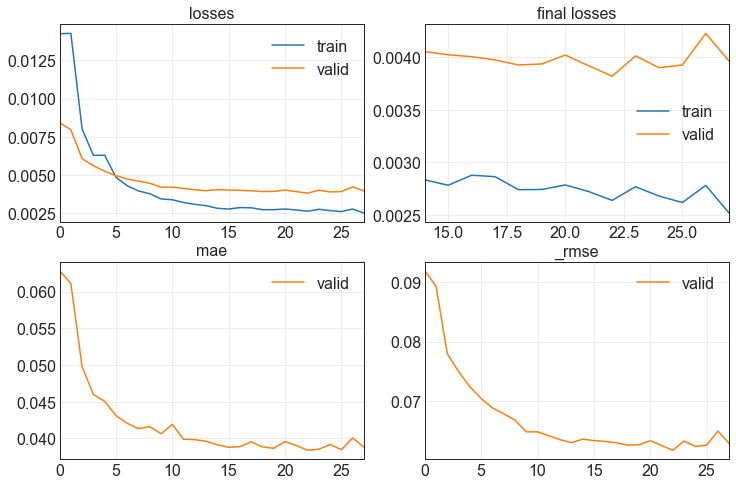

911.9598755836487                                                                                                      
[0.0025171057786792517, 0.003964292351156473, 0.038790494203567505, 0.06296262890100479]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 83%|████████████████████████████████▎      | 83/100 [8:34:24<2:46:36, 588.04s/trial, best loss: 0.0015439999988302588]

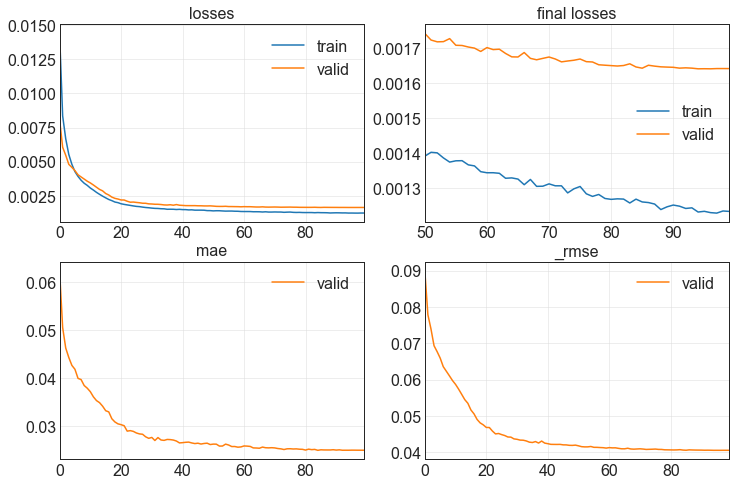

173.3415515422821                                                                                                      
[0.0012327524600550532, 0.001641602604649961, 0.024967225268483162, 0.040516696870326996]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 84%|████████████████████████████████▊      | 84/100 [8:37:22<2:04:01, 465.08s/trial, best loss: 0.0015439999988302588]

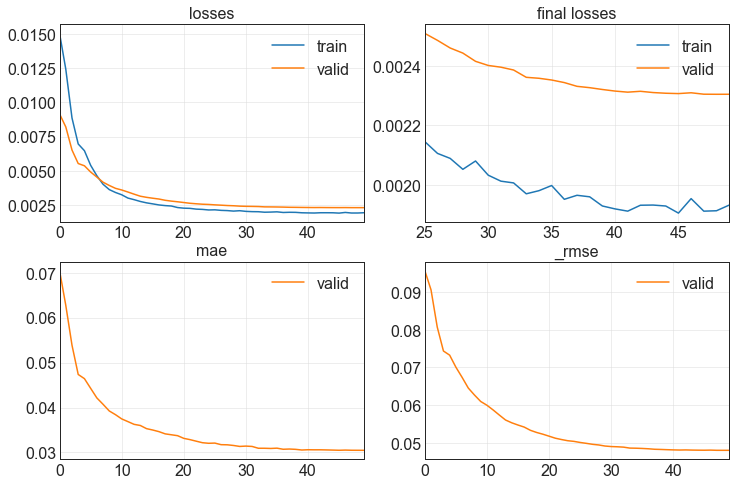

284.5473096370697                                                                                                      
[0.0019325809553265572, 0.0023049660958349705, 0.030472010374069214, 0.04801005870103836]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 85%|█████████████████████████████████▏     | 85/100 [8:42:11<1:43:05, 412.34s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 5: early stopping                                                                           
 85%|█████████████████████████████████▏     | 85/100 [8:45:12<1:43:05, 412.34s/trial, best loss: 0.0015439999988302588]

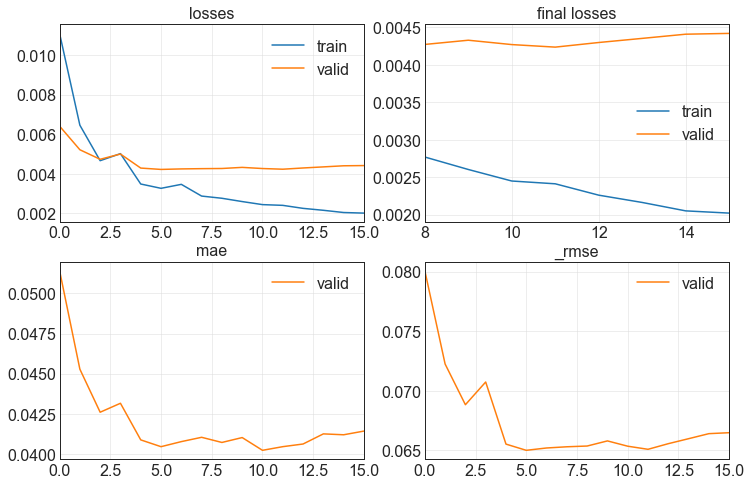

181.57094049453735                                                                                                     
[0.002019705716520548, 0.004420584533363581, 0.041430968791246414, 0.06648747622966766]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 86%|█████████████████████████████████▌     | 86/100 [8:45:18<1:20:23, 344.56s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 94: early stopping                                                                          
 86%|█████████████████████████████████▌     | 86/100 [8:50:35<1:20:23, 344.56s/trial, best loss: 0.0015439999988302588]

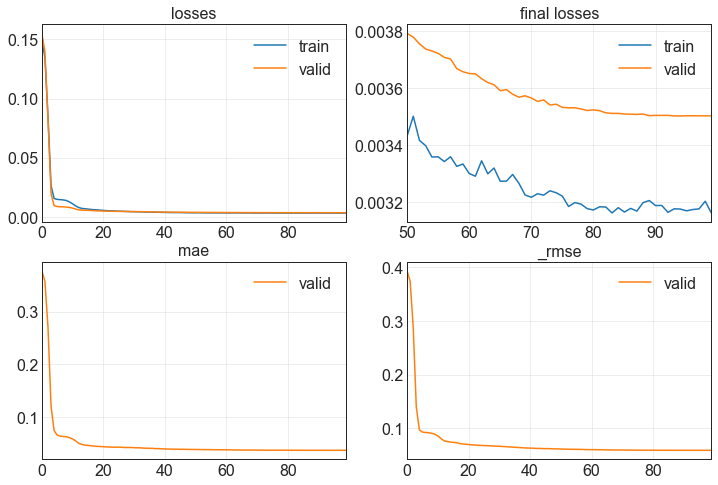

318.3014340400696                                                                                                      
[0.0031599465291947126, 0.0035021831281483173, 0.037520404905080795, 0.059179242700338364]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 87%|█████████████████████████████████▉     | 87/100 [8:50:41<1:13:15, 338.10s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 41: early stopping                                                                          
 87%|█████████████████████████████████▉     | 87/100 [8:57:14<1:13:15, 338.10s/trial, best loss: 0.0015439999988302588]

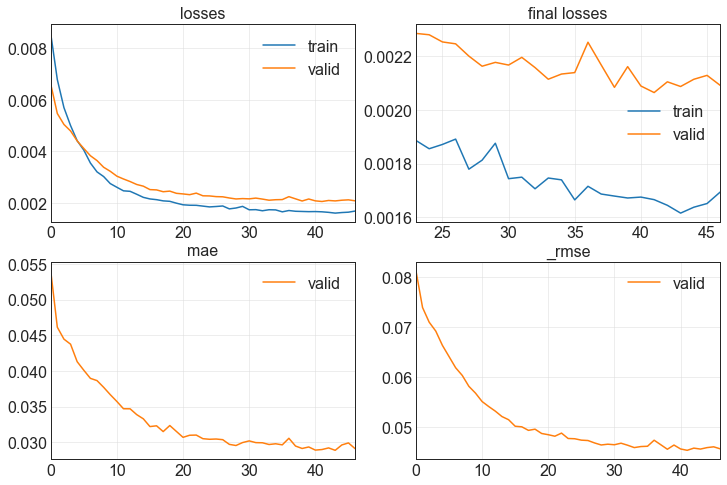

394.31759762763977                                                                                                     
[0.0016946016112342477, 0.0020913854241371155, 0.02912937104701996, 0.045731671154499054]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 88%|██████████████████████████████████▎    | 88/100 [8:57:20<1:11:16, 356.39s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 82: early stopping                                                                          
 88%|██████████████████████████████████▎    | 88/100 [9:24:47<1:11:16, 356.39s/trial, best loss: 0.0015439999988302588]

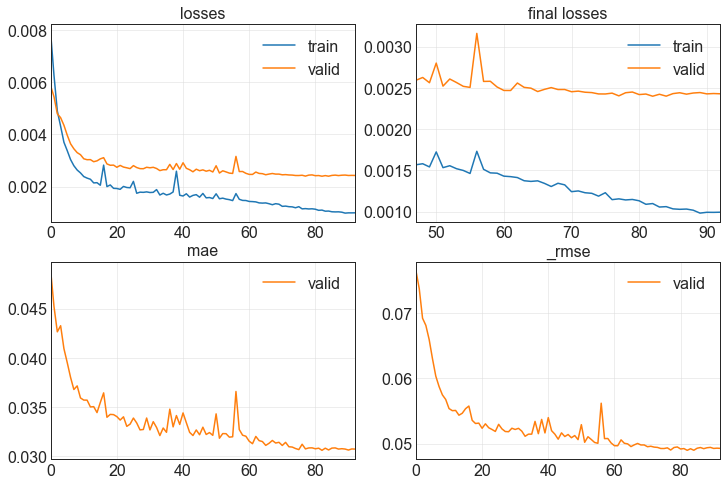

1647.8298857212067                                                                                                     
[0.0009918477153405547, 0.0024270780850201845, 0.030743274837732315, 0.049265388399362564]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 89%|██████████████████████████████████▋    | 89/100 [9:24:52<2:16:37, 745.22s/trial, best loss: 0.0015439999988302588]

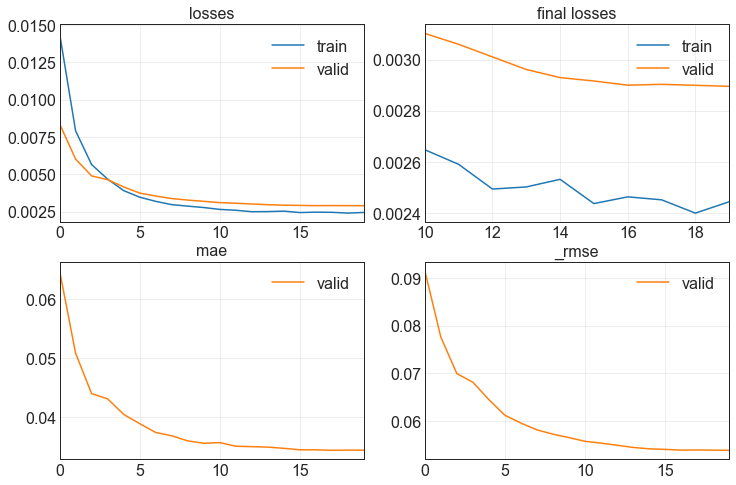

111.79028224945068                                                                                                     
[0.0024434213992208242, 0.0028952660504728556, 0.0343472883105278, 0.053807683289051056]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 90%|███████████████████████████████████    | 90/100 [9:26:49<1:32:47, 556.70s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 12: early stopping                                                                          
 90%|███████████████████████████████████    | 90/100 [9:29:04<1:32:47, 556.70s/trial, best loss: 0.0015439999988302588]

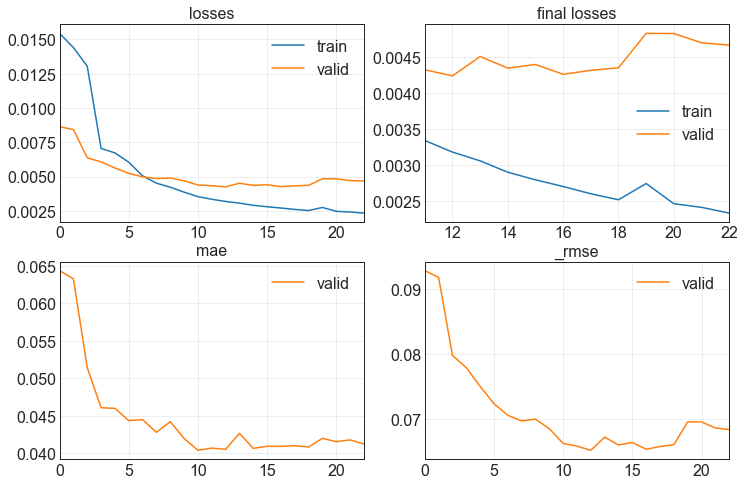

135.64573860168457                                                                                                     
[0.0023288314696401358, 0.004670148249715567, 0.0412624254822731, 0.06833848357200623]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 91%|███████████████████████████████████▍   | 91/100 [9:29:09<1:04:46, 431.83s/trial, best loss: 0.0015439999988302588]

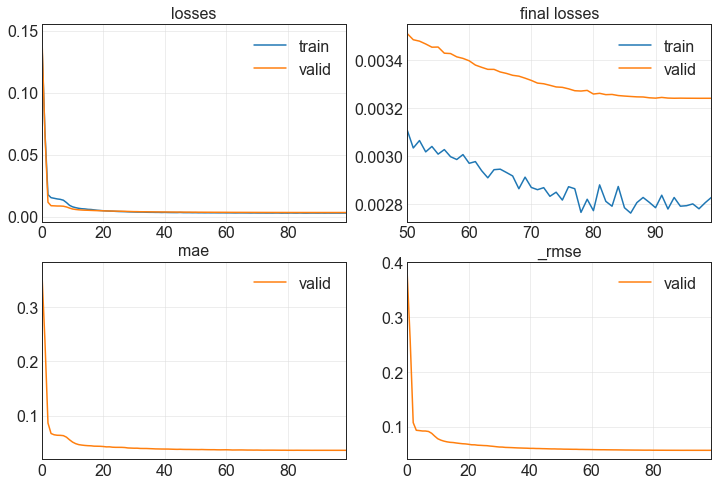

617.467381477356                                                                                                       
[0.0028294010553508997, 0.003242167178541422, 0.03597360849380493, 0.05694001540541649]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 92%|███████████████████████████████████▉   | 92/100 [9:39:32<1:05:11, 488.96s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 39: early stopping                                                                          
 92%|███████████████████████████████████▉   | 92/100 [9:41:56<1:05:11, 488.96s/trial, best loss: 0.0015439999988302588]

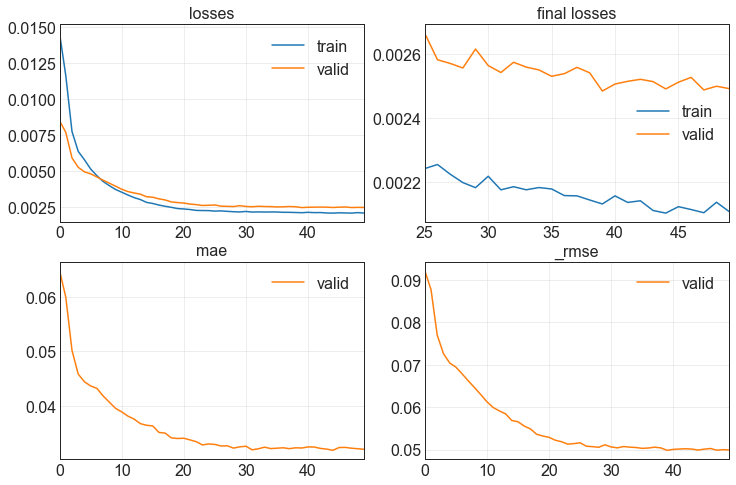

144.51347732543945                                                                                                     
[0.002107295673340559, 0.0024929330684244633, 0.03200767934322357, 0.04992928355932236]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 93%|██████████████████████████████████████▏  | 93/100 [9:42:01<45:09, 387.08s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 18: early stopping                                                                          
 93%|██████████████████████████████████████▏  | 93/100 [9:46:40<45:09, 387.08s/trial, best loss: 0.0015439999988302588]

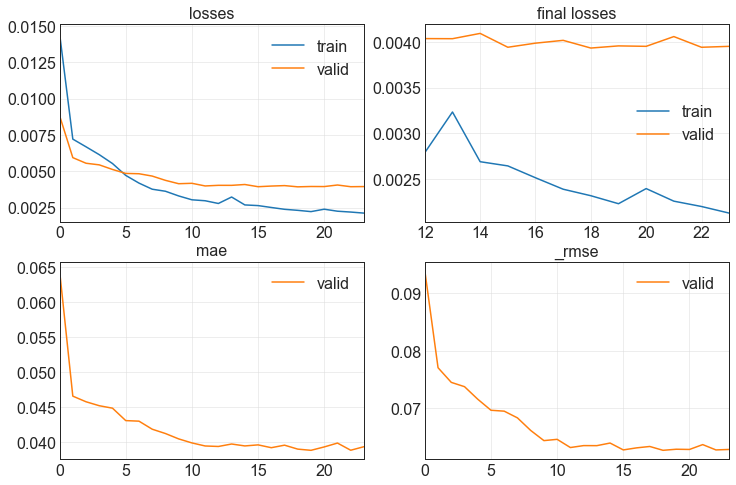

278.6586420536041                                                                                                      
[0.0021255244500935078, 0.003951127640902996, 0.039317820221185684, 0.062857985496521]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 94%|██████████████████████████████████████▌  | 94/100 [9:46:45<35:36, 356.11s/trial, best loss: 0.0015439999988302588]

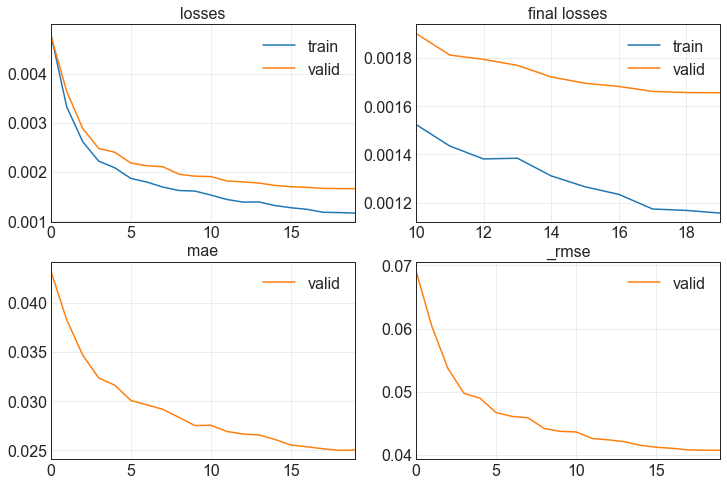

423.2222709655762                                                                                                      
[0.0011564054293558002, 0.001654773484915495, 0.024990927428007126, 0.040678899735212326]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 95%|██████████████████████████████████████▉  | 95/100 [9:53:53<31:28, 377.68s/trial, best loss: 0.0015439999988302588]

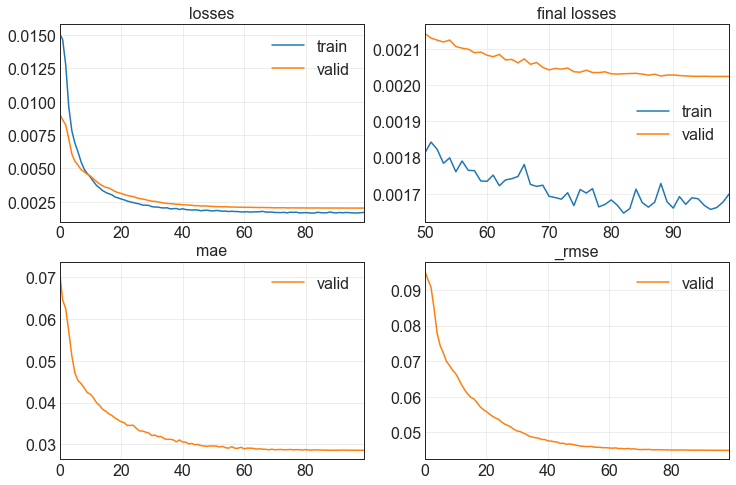

561.0624315738678                                                                                                      
[0.0016997304046526551, 0.0020240338053554296, 0.02858814224600792, 0.044989265501499176]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 96%|██████████████████████████████████████▍ | 96/100 [10:03:19<28:56, 434.13s/trial, best loss: 0.0015439999988302588]

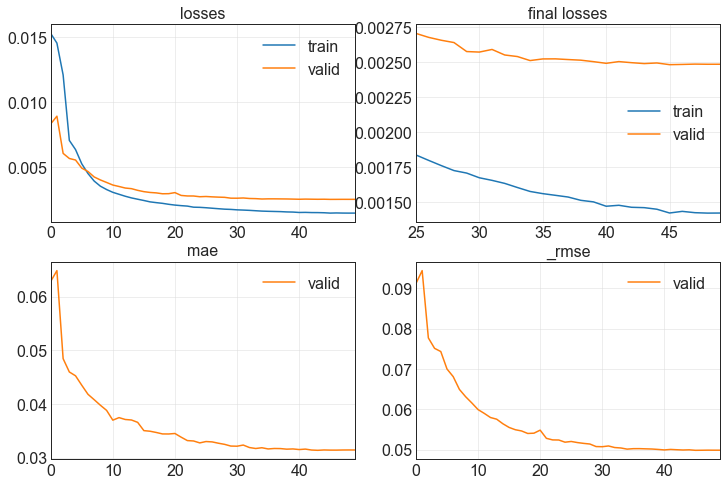

135.3524785041809                                                                                                      
[0.0014208743814378977, 0.0024840570986270905, 0.031419236212968826, 0.04984031245112419]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 97%|██████████████████████████████████████▊ | 97/100 [10:05:39<17:17, 345.96s/trial, best loss: 0.0015439999988302588]

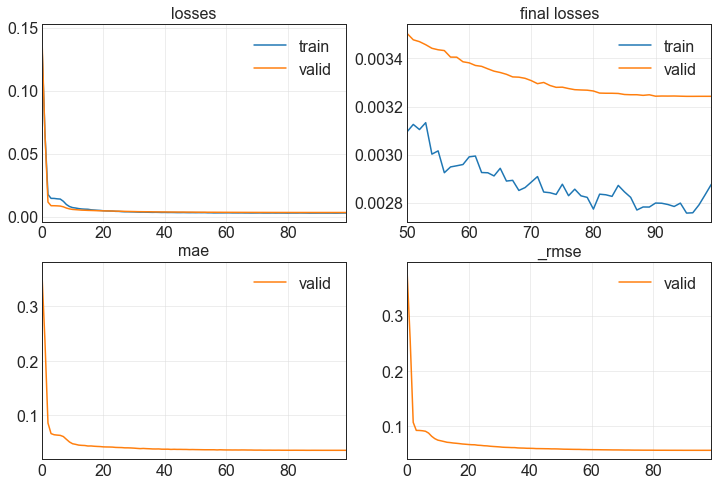

620.3546414375305                                                                                                      
[0.0028767806943506002, 0.0032424391247332096, 0.0360630638897419, 0.056942425668239594]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 5}
LSTM                                                                                                                   
 98%|███████████████████████████████████████▏| 98/100 [10:16:04<14:19, 429.72s/trial, best loss: 0.0015439999988302588]

No improvement since epoch 30: early stopping                                                                          
 98%|███████████████████████████████████████▏| 98/100 [10:21:40<14:19, 429.72s/trial, best loss: 0.0015439999988302588]

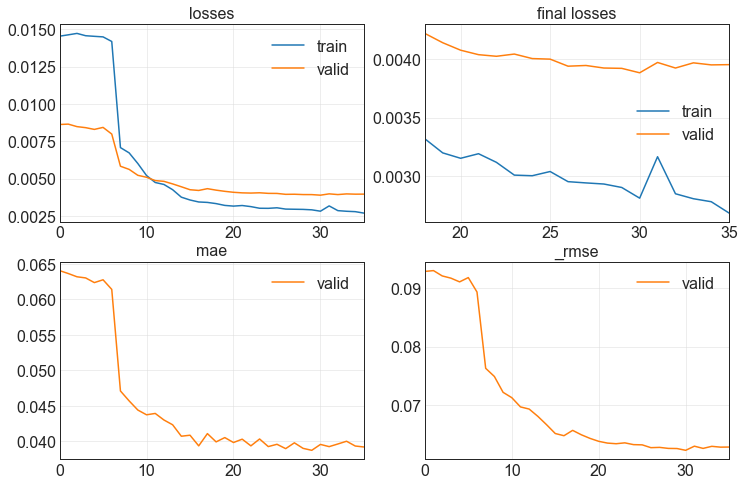

336.5176291465759                                                                                                      
[0.00268269213847816, 0.003954126033931971, 0.03918580710887909, 0.06288183480501175]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}
LSTM                                                                                                                   
 99%|███████████████████████████████████████▌| 99/100 [10:21:46<06:43, 403.24s/trial, best loss: 0.0015439999988302588]

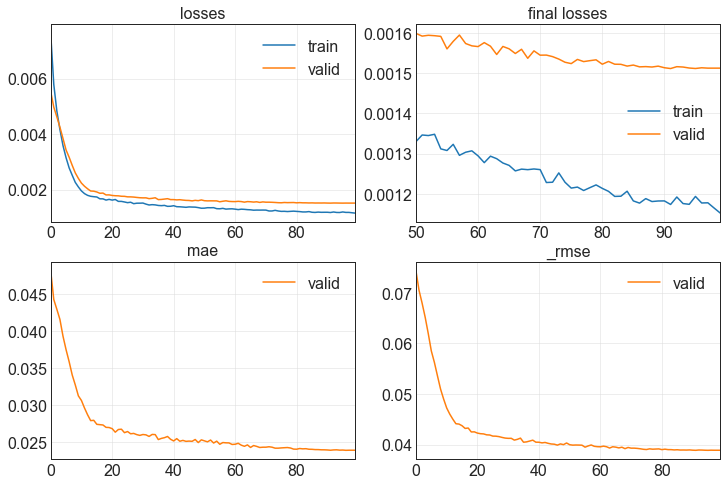

397.29289865493774                                                                                                     
[0.0011517723323777318, 0.001512613845989108, 0.023853961378335953, 0.03889233618974686]                               
100%|████████████████████████████████████████| 100/100 [10:28:23<00:00, 377.03s/trial, best loss: 0.001512613845989108]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001728D9B8438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(38467, 144, 10)

In [62]:
y.shape

(38467, 144)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = LSTM
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

LSTM


In [66]:
model

LSTM(
  (rnn): LSTM(144, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=144, bias=True)
)

In [67]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [68]:
model

Sequential(
  (0): LSTM(
    (rnn): LSTM(144, 200, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=400, out_features=144, bias=True)
  )
  (1): Sigmoid()
)

In [91]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

611,344 total parameters.
611,344 training parameters.


Training the model:

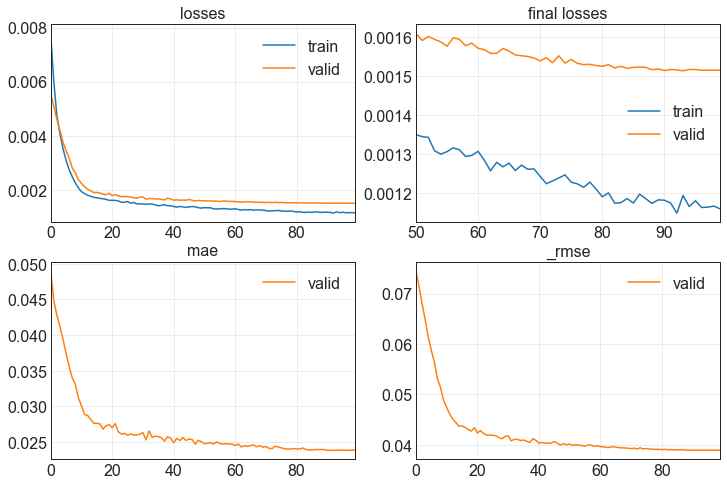

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

9619


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0059, 0.0154, 0.0301,  ..., 0.0258, 0.2175, 0.9246],
         [0.0089, 0.0175, 0.0300,  ..., 0.0259, 0.1974, 0.9137],
         [0.0074, 0.0200, 0.0297,  ..., 0.0269, 0.1946, 0.8610],
         ...,
         [0.3246, 0.0509, 0.1535,  ..., 0.0990, 0.4130, 0.9641],
         [0.2919, 0.0404, 0.1665,  ..., 0.0990, 0.4031, 0.9545],
         [0.3255, 0.0434, 0.1823,  ..., 0.1144, 0.4131, 0.9416]]),
 tensor([[0.0000, 0.0020, 0.0167,  ..., 0.0065, 0.2165, 0.8989],
         [0.0000, 0.0040, 0.0109,  ..., 0.0057, 0.2154, 0.7845],
         [0.0000, 0.0020, 0.0082,  ..., 0.0079, 0.2064, 1.0000],
         ...,
         [0.6255, 0.0400, 0.1464,  ..., 0.0790, 0.4122, 0.8162],
         [0.6294, 0.0634, 0.2009,  ..., 0.0886, 0.4169, 0.7650],
         [0.4050, 0.0551, 0.1543,  ..., 0.0931, 0.3980, 0.9314]]),
 tensor([[0.0059, 0.0154, 0.0301,  ..., 0.0258, 0.2175, 0.9246],
         [0.0089, 0.0175, 0.0300,  ..., 0.0259, 0.1974, 0.9137],
         [0.0074, 0.0200, 0.0297,  ..., 0.0269, 0.1946, 0.

In [73]:
test_targets.shape

torch.Size([9619, 144])

In [74]:
test_preds.shape

torch.Size([9619, 144])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(9619, 1, 144)

In [78]:
y_pred.shape

(9619, 1, 144)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(9619, 1, 144)

In [83]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  397.16905426979065
Test time (in seconds):  0.715217113494873


In [92]:
print('Training time (in seconds) per epoch: ', 397.16905426979065 / 100)

Training time (in seconds) per epoch:  3.9716905426979063


Calculate the RMSE and MAE for differnt time steps:

In [87]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  8.283820403696977
MAE:  4.002971509427864


Plot the RMSE and MAE distributions for each time step:

In [88]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [89]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

LSTM_TM-minmax_RMSE-10-1-step-1.pdf
LSTM_TM-minmax_MAE-10-1-step-1.pdf


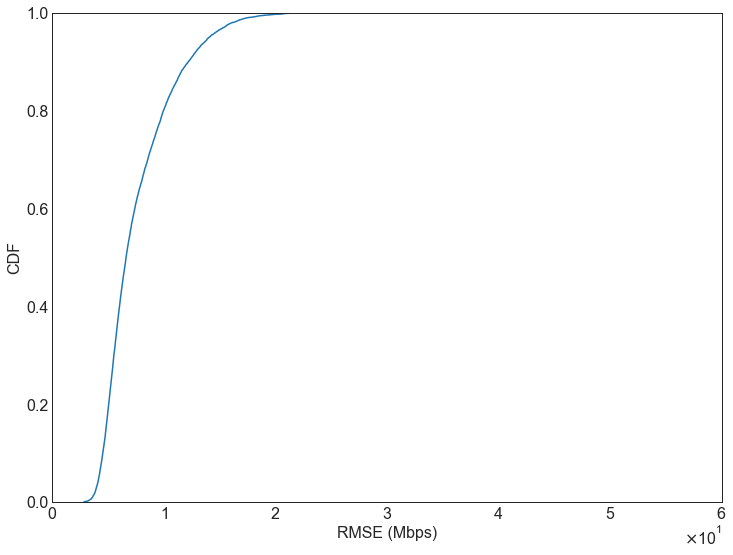

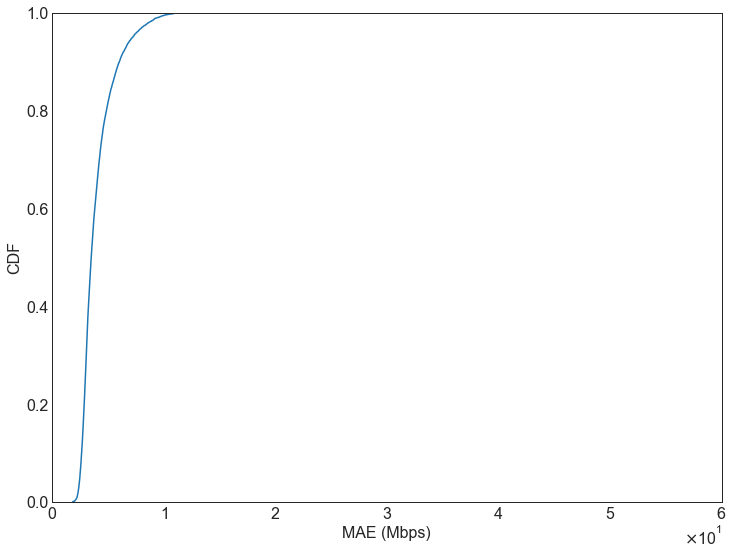

In [90]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)